In [81]:
import sys
from pathlib import Path

# Get the folder where this notebook is running
notebook_path = Path().resolve()

# Assume 'src' is at the project root, one level up from the notebook folder
project_root = notebook_path.parent

# Construct the full path to src
src_path = project_root / "src"

# Add src to sys.path if not already there
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))

print(f"Added {src_path} to sys.path")

Added /home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/src to sys.path


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.stats import linregress
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn import set_config
from functools import reduce
import warnings


from powerco_churn.EDA.basic_data_wrangling import basic_wrangling
from powerco_churn.EDA.univariate_statistics import univariate_statistics, plot_histograms_countplots
from powerco_churn.EDA.bivariate_statistics import bivariate_stats
from powerco_churn.EDA.visualizing_bivariate_statistics import generate_bar_plot
from powerco_churn.EDA.outliers import clean_outliers, search_eps_dbscan, clean_outliers_using_dbscan
from powerco_churn.EDA.skewness import correct_skew
from powerco_churn.EDA.date_utils import parse_and_format_dates

# Configuration

In [83]:
# plot will similiar to ggplot
plt.style.use('ggplot')

random_seed = 42

#set output of skllearn to be a pandas dataframe
set_config(transform_output = "default")


# Load Data

Two dataframes:

- client_data containing information about the clients
- price_data containing the prices of power and energy during 2015

In [84]:
client_data = pd.read_csv('../data/raw/client_data.csv')


In [85]:
number_clients = len(client_data)
not_churned = sum(client_data['churn'] == 0)
churned = sum(client_data['churn'] == 1)

print(f'Number of Clients: {number_clients}')
print(f'Number of clients that did not churn: {not_churned}')
print(f'Number of clients that churned: {churned}')
print(f'Proportion of clients that chunned: {100*churned/number_clients:.2f}%')

Number of Clients: 14606
Number of clients that did not churn: 13187
Number of clients that churned: 1419
Proportion of clients that chunned: 9.72%


In [86]:
price_data = pd.read_csv('../data/raw/price_data.csv')

# Train test split

In [7]:
train_client_data, test_client_data = train_test_split(client_data, test_size = 0.2, 
                                random_state = random_seed,
                                stratify = client_data['churn'])

In [8]:
print('Train data: Proportion of clients that chunned: {:.2f}%'.format(100*sum(train_client_data['churn'] == 1)/len(train_client_data)))
print('Test data: Proportion of clients that chunned: {:.2f}%'.format(100*sum(test_client_data['churn'] == 1)/len(test_client_data)))

Train data: Proportion of clients that chunned: 9.71%
Test data: Proportion of clients that chunned: 9.72%


In [9]:
del client_data

# Data Description

## Client Data

In [10]:
train_client_data.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn'],
      dtype='object')

- id = client company identifier;
- channel_sales = code of the sales channel;
- cons_12m = electricity consumption of the past 12 months;
- cons_gas_12m = gas consumption of the past 12 months;
- cons_last_month = electricity consumption of the last month;
- date_activ = date of activation of the contract;
- date_end = registered date of the end of the contract;
- date_modif_prod = date of the last modification of the product;
- date_renewal = date of the next contract renewal;
- forecast_cons_12m = forecasted electricity consumption for next 12 months;
- forecast_cons_year = forecasted electricity consumption for the next calendar year;
- forecast_discount_energy = forecasted value of current discount;
- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months;
- forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak);
- forecast_price_energy_peak = forecasted energy price for 2nd period (peak);
- forecast_price_pow_off_peak = forecasted power price for 1st period (off peak);
- has_gas = indicated if client is also a gas client;
- imp_cons = current paid consumption;
- margin_gross_pow_ele = gross margin on power subscription;
  - It basically refers to the profit margin a power provider makes from selling electricity (or other energy)
    subscriptions—before accounting for overhead costs like salaries, rent, or admin;
  - Gross Margin = Revenue from power subscription - Direct costs of supplying the power;  
- margin_net_pow_ele = net margin on power subscription;
  - Net margin (also called net profit margin) shows how much actual profit a power provider makes
    after all expenses are subtracted, not just the direct ones;
  - Net Profit = Total Revenue – All Costs (direct costs + operating expenses + taxes + interest + depreciation, etc.)      
- nb_prod_act = number of active products and services;
- net_margin = total net margin;
- num_years_antig = antiquity of the client (in number of years);
- origin_up = code of the electricity campaign the customer first subscribed to;
- pow_max = subscribed power
- churn = has the client churned over the next 3 months


## Price Data

- id = client company identifier
- price_date = reference date
- price_off_peak_var = price of energy for the 1st period (off peak)
- price_peak_var = price of energy for the 2nd period (peak)
- price_mid_peak_var = price of energy for the 3rd period (mid peak)
- price_off_peak_fix = price of power for the 1st period (off peak)
- price_peak_fix = price of power for the 2nd period (peak)
- price_mid_peak_fix = price of power for the 3rd period (mid peak)


# EDA


## Client Data

### Date Features

- date_activ;
- date_end;
- date_modif_prod;
- date_renewal. 

In [11]:
date_features = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

In [12]:
# parse and format dates
#the format that will be used for dates is "%Y-%m-%d"

for feature in date_features:
    train_client_data[feature] = train_client_data[feature].apply(parse_and_format_dates)



In [13]:
def print_firt_last_date(df, feature):
    """
    Print the first and last date of a feature

    Parameters
    ----------
    df : DataFrame
        DataFrame containing the feature
    feature : str
        Name of the feature
    """
    print(feature)
    print(f'First date: {df[feature].min()}')
    print(f'Last date: {df[feature].max()}')


for feature in ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']:
    print_firt_last_date(train_client_data, feature)
    print('')

date_activ
First date: 2003-06-05
Last date: 2013-11-08

date_end
First date: 2016-01-28
Last date: 2017-06-13

date_modif_prod
First date: 2003-06-05
Last date: 2016-01-29

date_renewal
First date: 2013-06-26
Last date: 2016-01-28



#### Feature Engineering date features

- There is already a feature that that indicates how long the client has been with the energy company;
- Creating a new feature that indicates the length of the active contract;
- How long will it take for the contract to end?
- How long since the last modification?


In [14]:
train_client_data['contract_length'] = (pd.to_datetime(train_client_data['date_end'])
                                         - pd.to_datetime(train_client_data['date_activ'])).dt.days

In [15]:
# a random date selected to be more recent than the last date in the dataset
reference_date = pd.to_datetime('2020-01-01')

train_client_data['days_until_end'] = (reference_date - pd.to_datetime(train_client_data['date_end'])).dt.days
train_client_data['days_since_modification'] = (reference_date - pd.to_datetime(train_client_data['date_modif_prod'])).dt.days

### Univariate Statistics


In [16]:
train_client_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11684 entries, 6834 to 9452
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              11684 non-null  object 
 1   channel_sales                   11684 non-null  object 
 2   cons_12m                        11684 non-null  int64  
 3   cons_gas_12m                    11684 non-null  int64  
 4   cons_last_month                 11684 non-null  int64  
 5   date_activ                      11684 non-null  object 
 6   date_end                        11684 non-null  object 
 7   date_modif_prod                 11684 non-null  object 
 8   date_renewal                    11684 non-null  object 
 9   forecast_cons_12m               11684 non-null  float64
 10  forecast_cons_year              11684 non-null  int64  
 11  forecast_discount_energy        11684 non-null  float64
 12  forecast_meter_rent_12m         116

In [17]:
train_client_data.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,contract_length,days_until_end,days_since_modification
count,1.168400e+04,1.168400e+04,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,...,11684.000000,11684.00000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000,11684.000000
mean,1.594292e+05,2.784362e+04,16149.338925,1868.707400,1426.479374,0.956779,63.059956,0.137265,0.050650,43.143748,...,24.552052,24.54937,1.292622,189.985665,5.002054,18.193975,0.097141,2008.448819,1252.196765,2559.209089
std,5.717528e+05,1.630528e+05,64088.349330,2419.607791,3414.981892,5.074799,65.964227,0.024675,0.048968,4.545281,...,20.303727,20.30364,0.721429,331.655260,1.606180,13.910967,0.296163,602.749301,107.041420,924.312627
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,0.000000,2.000000,3.300000,0.000000,941.000000,932.000000,1433.000000
25%,5.609000e+03,0.000000e+00,0.000000,488.340000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,...,14.260000,14.26000,1.000000,49.690000,4.000000,12.500000,0.000000,1461.000000,1156.000000,1660.000000
50%,1.413900e+04,0.000000e+00,813.000000,1099.430000,321.000000,0.000000,18.725000,0.143166,0.084138,44.311378,...,21.640000,21.64000,1.000000,111.750000,5.000000,13.856000,0.000000,1854.000000,1250.000000,2434.000000
75%,4.112150e+04,0.000000e+00,3435.000000,2404.182500,1769.000000,0.000000,131.020000,0.146348,0.098837,44.311378,...,29.850000,29.85000,1.000000,243.975000,6.000000,19.300000,0.000000,2351.500000,1343.000000,3437.000000
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,...,374.640000,374.64000,32.000000,24570.650000,13.000000,320.000000,1.000000,4749.000000,1434.000000,6054.000000


In [18]:
univariate_stats_client_data = univariate_statistics(train_client_data)
univariate_stats_client_data

,type,count,missing,unique,mode,min_value,q_1,median,q_3,max_value,mean,std,skew,kurtosis
feature,,,,,,,,,,,,,,
id,object,11684,0,11684,0002203ffbb812588b632b9e628cc38d,-,-,-,-,-,-,-,-,-
channel_sales,object,11684,0,8,foosdfpfkusacimwkcsosbicdxkicaua,-,-,-,-,-,-,-,-,-
cons_12m,int64,11684,0,9219,0,0,5609.0,14139.0,41121.5,6207104,159429.231,571752.758,6.029,43.573
cons_gas_12m,int64,11684,0,1716,0,0,0.0,0.0,0.0,4154590,27843.623,163052.758,10.009,139.96
cons_last_month,int64,11684,0,4225,0,0,0.0,813.0,3435.0,771203,16149.339,64088.349,6.378,47.921
date_activ,object,11684,0,1685,2010-02-01,-,-,-,-,-,-,-,-,-
date_end,object,11684,0,366,2016-02-01,-,-,-,-,-,-,-,-,-
date_modif_prod,object,11684,0,1997,2015-11-01,-,-,-,-,-,-,-,-,-
date_renewal,object,11684,0,372,2015-06-23,-,-,-,-,-,-,-,-,-


### Univariate Statistics - Visualization

In [19]:
#plot_histograms_countplots(train_client_data)

### Bivariate Statistics 

Correlation betwen each feature in the train_client target and the output feature.

In [20]:
bivariate_stats_client_data = bivariate_stats(train_client_data, target = 'churn')
bivariate_stats_client_data

,missing,type,unique_values,skew,pearson_pvalue,r,y = mx + b,spearman,spearman_pvalue,kendalltau,kendalltau_pvalue,chi2,chi2_pvalue,ttest,ttest_pvalue,F,F_pvalue
id,0.0%,object,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
channel_sales,0.0%,object,-,2.721,-,-,-,-,-,-,-,-,-,-,-,12.618,0.0
cons_12m,0.0%,int64,-,6.029,0.0,-0.046,y = -0.0x + 0.101,-0.003,0.719,-0.003,0.719,-,-,-,-,-,-
cons_gas_12m,0.0%,int64,-,10.009,0.0,-0.037,y = -0.0x + 0.099,-0.016,0.085,-0.015,0.085,-,-,-,-,-,-
cons_last_month,0.0%,int64,-,6.378,0.0,-0.045,y = -0.0x + 0.1,-0.01,0.291,-0.008,0.291,-,-,-,-,-,-
date_activ,0.0%,object,-,2.721,-,-,-,-,-,-,-,-,-,-,-,1.143,0.0
date_end,0.0%,object,-,2.721,-,-,-,-,-,-,-,-,-,-,-,1.207,0.005
date_modif_prod,0.0%,object,-,2.721,-,-,-,-,-,-,-,-,-,-,-,1.123,0.0
date_renewal,0.0%,object,-,2.721,-,-,-,-,-,-,-,-,-,-,-,0.975,0.621
forecast_cons_12m,0.0%,float64,-,7.775,0.121,0.014,y = 0.0x + 0.094,0.01,0.268,0.008,0.268,-,-,-,-,-,-


In [21]:
#change - to nan to be able to sort

bivariate_stats_client_data.loc[bivariate_stats_client_data['r']=='-','r'] = np.nan
bivariate_stats_client_data.loc[bivariate_stats_client_data['spearman']=='-','spearman'] = np.nan
bivariate_stats_client_data.loc[bivariate_stats_client_data['kendalltau']=='-','kendalltau'] = np.nan


In [22]:
bivariate_stats_client_data.sort_values(by = 'r', ascending = False)

,missing,type,unique_values,skew,pearson_pvalue,r,y = mx + b,spearman,spearman_pvalue,kendalltau,kendalltau_pvalue,chi2,chi2_pvalue,ttest,ttest_pvalue,F,F_pvalue
margin_gross_pow_ele,0.0%,float64,-,4.575,0.0,0.099,y = 0.001x + 0.062,0.106,0.0,0.087,0.0,-,-,-,-,-,-
margin_net_pow_ele,0.0%,float64,-,4.576,0.0,0.099,y = 0.001x + 0.062,0.106,0.0,0.087,0.0,-,-,-,-,-,-
net_margin,0.0%,float64,-,37.744,0.0,0.047,y = 0.0x + 0.089,0.025,0.007,0.02,0.007,-,-,-,-,-,-
forecast_meter_rent_12m,0.0%,float64,-,1.438,0.0,0.042,y = 0.0x + 0.085,0.039,0.0,0.032,0.0,-,-,-,-,-,-
forecast_price_energy_peak,0.0%,float64,-,-0.024,0.001,0.032,y = 0.194x + 0.087,0.038,0.0,0.034,0.0,-,-,-,-,-,-
pow_max,0.0%,float64,-,6.01,0.001,0.031,y = 0.001x + 0.085,0.036,0.0,0.031,0.0,-,-,-,-,-,-
forecast_cons_12m,0.0%,float64,-,7.775,0.121,0.014,y = 0.0x + 0.094,0.01,0.268,0.008,0.268,-,-,-,-,-,-
days_until_end,0.0%,int64,-,0.038,0.142,0.014,y = 0.0x + 0.05,0.013,0.151,0.011,0.151,-,-,-,-,-,-
forecast_price_pow_off_peak,0.0%,float64,-,-4.905,0.15,0.013,y = 0.001x + 0.06,-0.028,0.002,-0.026,0.002,-,-,-,-,-,-
forecast_discount_energy,0.0%,float64,-,5.179,0.207,0.012,y = 0.001x + 0.096,0.013,0.156,0.013,0.156,-,-,-,-,-,-


### Bivariate Statistics - Visualization


In [23]:
univariate_stats_client_data.loc[:,['type','unique']]

,type,unique
feature,,
id,object,11684
channel_sales,object,8
cons_12m,int64,9219
cons_gas_12m,int64,1716
cons_last_month,int64,4225
date_activ,object,1685
date_end,object,366
date_modif_prod,object,1997
date_renewal,object,372


#### Categorical Features 


- channel_sales;
- has_gas;
- nb_prod_act;
- num_years_antig;
- origin_up;
- forecast_discount_energy	

Some of these features are not categorical, they are numeric but they have a low number of unique values.

Generating stacked bar plots for categorical features with a low number of categorical features

In [24]:
def calculate_proportion_by_feature(df: pd.DataFrame
                                        , feature: str, 
                                         output_culumn: str = 'churn') -> pd.DataFrame:
    """
    Computes the proportion of each unique value in a feature with respect to each class in the output column.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    feature : str
        Name of the feature to calculate the proportion for.
    output_culumn : str, optional
        Name output column, by default 'churn'

    Returns
    -------
    pd.DataFrame containing the proportion of churned clients for each inique value in the feature
    """


    df_proportion = df.copy()
    df_proportion = df_proportion.groupby([feature, output_culumn])[feature].count().unstack()
    df_proportion = df_proportion.divide(df_proportion.sum(axis=1), axis=0)
    
    return df_proportion



def annotate_stacked_bars(ax, colour="white", textsize=13):
   
   """
   Adds anotations to the bars of a stacked bar plot.

   Parameters
   ----------
   ax : matplotlib.axes.Axes
       The axes object of the plot.
   colour : str, optional
       The color of the annotation, by default "white"
   textsize : int, optional
       The size of the annotation, by default 13

   """

   for individual_bar in ax.patches: #loop each bar
      height = individual_bar.get_height() 
      if height == 0: #
            continue
      value = f'{height: .1%}' if height <=1 else str(round(height, 1)) 
      x = individual_bar.get_x() + individual_bar.get_width() / 2    
      y = individual_bar.get_y() + height / 2 
      ax.annotate(value, (x, y), 
                  ha='center', 
                  va='center', 
                  color=colour, 
                  fontsize=textsize)
      ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


def plot_stacked_bars(  df: pd.DataFrame,
                        feature: str,
                        output_feature: str,
                        x_label: str, 
                        y_label: str, 
                        title: str,
                        legends: list = ['Churned', 'Not Churned'], 
                        figsize: tuple=(10, 6), 
                        colour_palette: list = ['blue', 'salmon'] ):
   """
   Function to plot stacked bars

   Parameters
   ----------
   df : pd.DataFrame
       DataFrame containing the data. 
   feature : str
       Feature to plot.
   output_feature : str
       Output feature.
   x_label : str
       Label for the x-axis.
   y_label : str
       Label for the y-axis.
   title : str
       Title for the plot.
   legends : list, optional
       List of legends for the plot, by default ['Churned', 'Not Churned']
   figsize : tuple, optional
       Size of the figure, by default (10, 6)
   colour_palette : list, optional
       List of colors for the plot, by default ['blue', 'salmon']
   """   
   dataframe = calculate_proportion_by_feature(df, feature, output_feature)

   if colour_palette is None:
            colour_palette = sns.color_palette("pastel", len(legends))
      
   ax = dataframe.plot(kind='bar', stacked=True, figsize=figsize, color =colour_palette)
   ax.set_xlabel(x_label)
   ax.set_ylabel(y_label)
   ax.set_title(title)
   plt.legend(legends, loc='upper right')
   plt.tight_layout()
   annotate_stacked_bars(ax, colour="white", textsize=13)
   ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
   if len(dataframe) == 1:
      plt.xticks([])

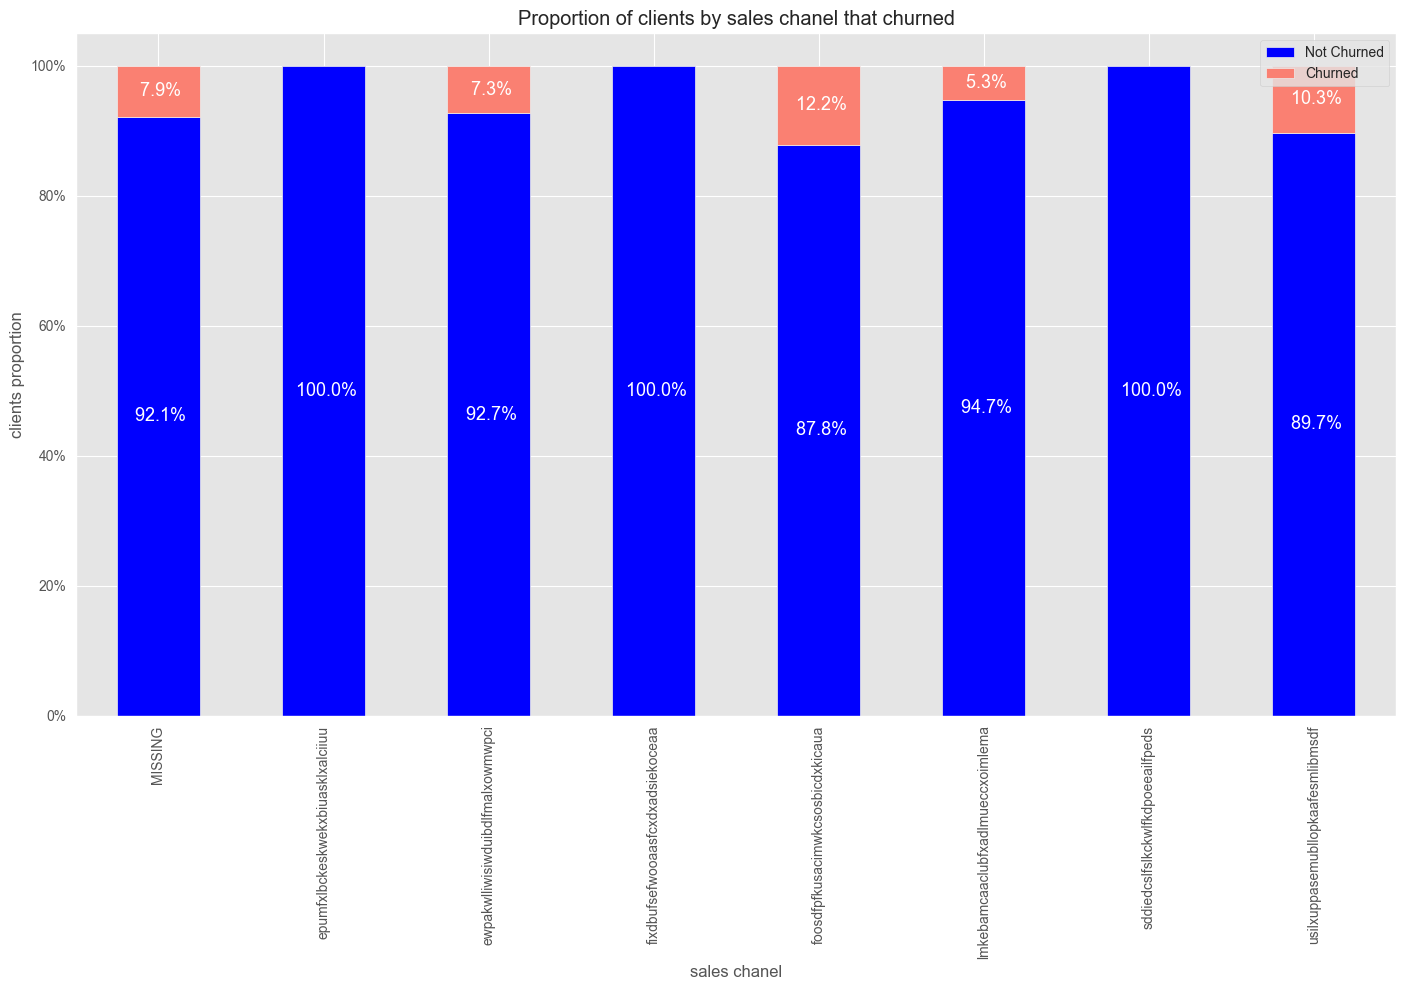

In [25]:
plot_stacked_bars(df = train_client_data, 
                feature = 'channel_sales', 
                output_feature = 'churn', 
                x_label = 'sales chanel', 
                y_label = 'clients proportion', 
                title ='Proportion of clients by sales chanel that churned', 
                legends =  ['Not Churned', 'Churned'], 
                figsize=(14, 10))

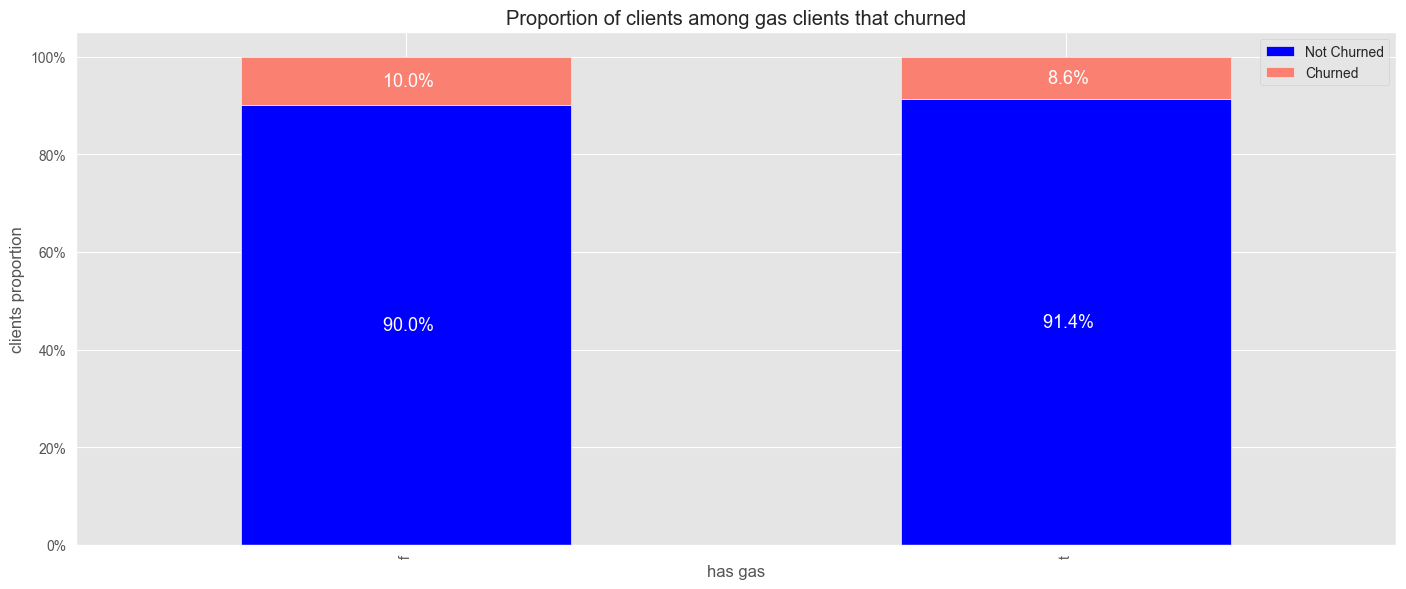

In [26]:
plot_stacked_bars(df = train_client_data, 
                feature = 'has_gas', 
                output_feature = 'churn', 
                x_label = 'has gas', 
                y_label = 'clients proportion', 
                title ='Proportion of clients among gas clients that churned', 
                legends =  ['Not Churned', 'Churned'], 
                figsize=(14, 6))

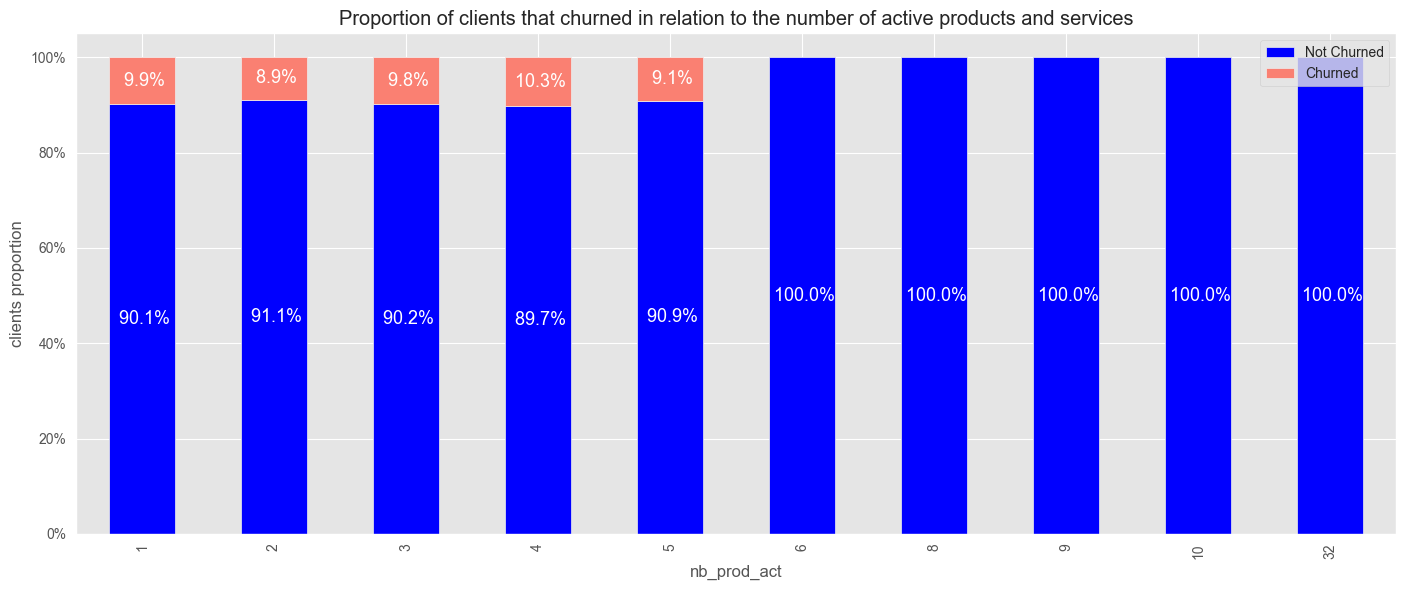

In [27]:
plot_stacked_bars(df = train_client_data, 
                feature = 'nb_prod_act', 
                output_feature = 'churn', 
                x_label = 'nb_prod_act', 
                y_label = 'clients proportion', 
                title ='Proportion of clients that churned in relation to the number of active products and services', 
                legends =  ['Not Churned', 'Churned'], 
                figsize=(14, 6))

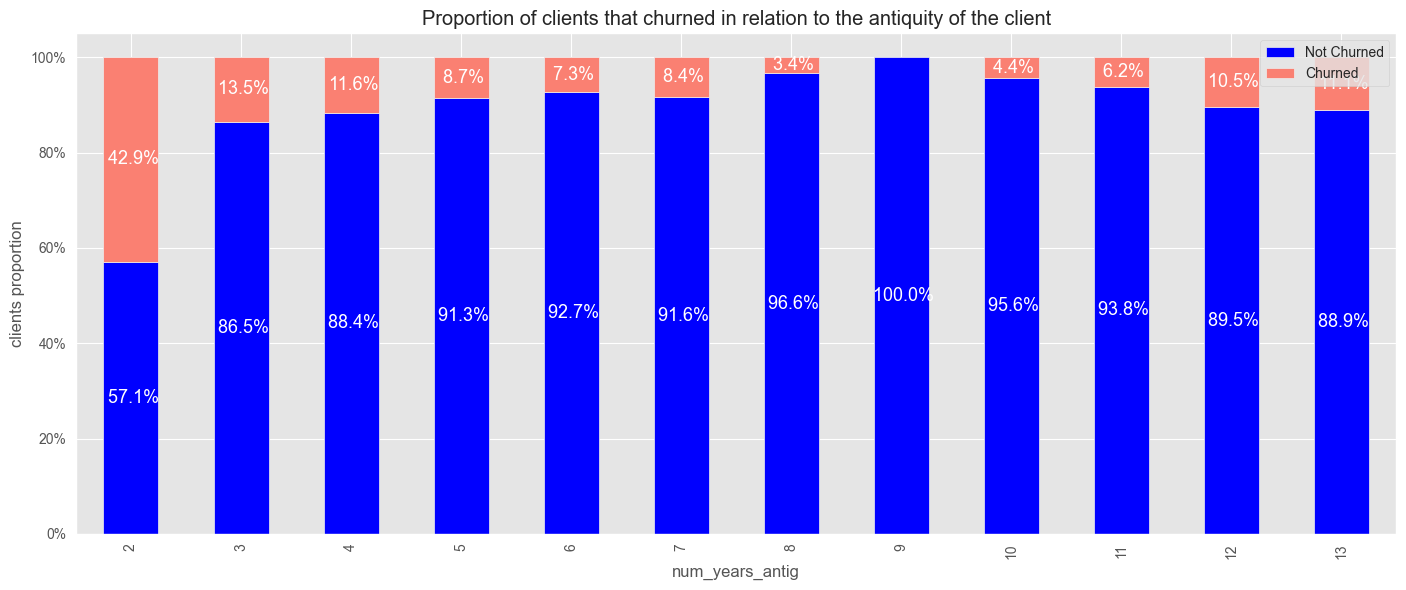

In [28]:
plot_stacked_bars(df = train_client_data, 
                feature = 'num_years_antig', 
                output_feature = 'churn', 
                x_label = 'num_years_antig', 
                y_label = 'clients proportion', 
                title ='Proportion of clients that churned in relation to the antiquity of the client', 
                legends =  ['Not Churned', 'Churned'], 
                figsize=(14, 6))

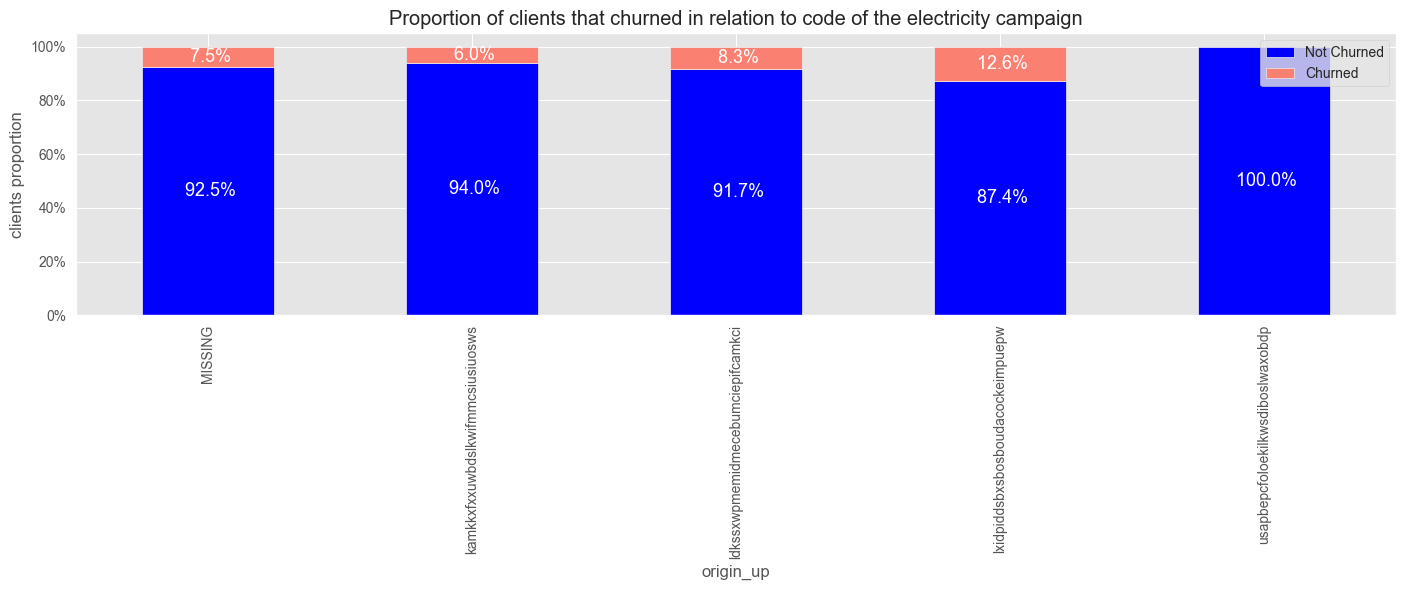

In [29]:
plot_stacked_bars(df = train_client_data, 
                feature = 'origin_up', 
                output_feature = 'churn', 
                x_label = 'origin_up', 
                y_label = 'clients proportion', 
                title ='Proportion of clients that churned in relation to code of the electricity campaign', 
                legends =  ['Not Churned', 'Churned'], 
                figsize=(14, 6))

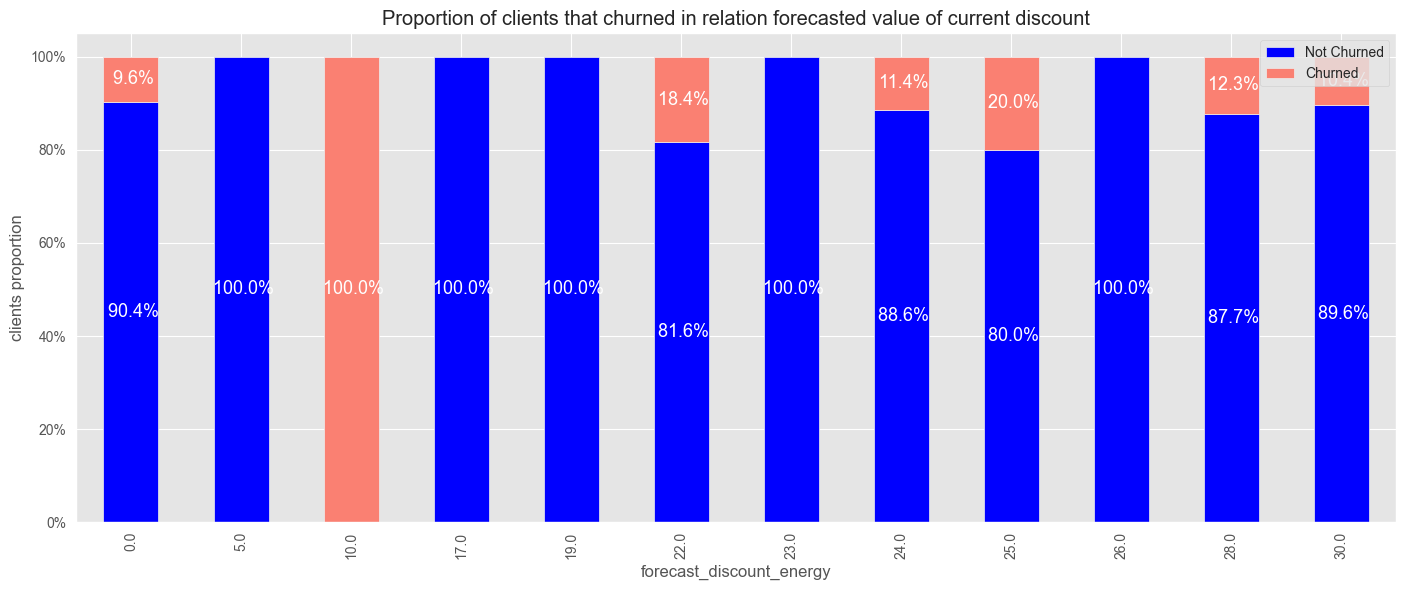

In [30]:
plot_stacked_bars(df = train_client_data, 
                feature = 'forecast_discount_energy', 
                output_feature = 'churn', 
                x_label = 'forecast_discount_energy', 
                y_label = 'clients proportion', 
                title ='Proportion of clients that churned in relation forecasted value of current discount', 
                legends =  ['Not Churned', 'Churned'], 
                figsize=(14, 6))

#### Numeric Features

##### Barplots

Piloting bar plots of the mean of the numeric features. The means are calculated for clients who churned and those who did not churn. The ttest was conducted to compare the means of the numeric features between the two groups.

In [31]:
numeric_columns = train_client_data.select_dtypes(include='number').columns.to_list()
numeric_columns.remove('churn')
numeric_columns

['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'forecast_cons_12m',
 'forecast_cons_year',
 'forecast_discount_energy',
 'forecast_meter_rent_12m',
 'forecast_price_energy_off_peak',
 'forecast_price_energy_peak',
 'forecast_price_pow_off_peak',
 'imp_cons',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'nb_prod_act',
 'net_margin',
 'num_years_antig',
 'pow_max',
 'contract_length',
 'days_until_end',
 'days_since_modification']

In [32]:
#for feature in numeric_columns:
#  generate_bar_plot(train_client_data, feature, 'churn', plot_type='bar')


### Outliers

Detecting and treating outliers.

In [33]:
numeric_columns

['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'forecast_cons_12m',
 'forecast_cons_year',
 'forecast_discount_energy',
 'forecast_meter_rent_12m',
 'forecast_price_energy_off_peak',
 'forecast_price_energy_peak',
 'forecast_price_pow_off_peak',
 'imp_cons',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'nb_prod_act',
 'net_margin',
 'num_years_antig',
 'pow_max',
 'contract_length',
 'days_until_end',
 'days_since_modification']

In [34]:
def plot_histogram_boxplot_sidebyside(df: pd.DataFrame, 
                                      list_features: list,
                                      figsize: tuple = (12, 6)):
    """
    Function to plot histogram and boxplot side by side in a single figure

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data. 
    list_features : list
        List of features to plot.
    figsize : tuple, optional
        Size of the figure, by default (12, 6)
    """

    for feature in list_features:
        fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = figsize)
        sns.boxplot(data = df, y = feature, ax = axs[0])
        sns.histplot(data = df, x = feature, ax = axs[1], stat = 'density')

In [35]:
# Plot a histogram and a boxplot of each feature in the dataframer
#plot_histogram_boxplot_sidebyside(df = train_client_data, 
#                                  list_features = numeric_columns)


#### Treating outliers one feature at a time

Three different treatments will be applied to outliers:

- Remove : remove rows containing outliers;
- Replace: replace outliers by fix values;
- Impute: calculate the value to replace the outliers.

In [36]:
def compare_distributions(raw_data: pd.DataFrame,
                          clean: pd.DataFrame,
                          list_features: list,
                          clean_method: str,
                          figsize: tuple = (12, 6)):
    """
    Function to plot a histogram of the raw data and the cleaned data side by side

    Parameters
    ----------
    raw_data : pd.DataFrame
        DataFrame containing the raw data.
    clean : pd.DataFrame
        DataFrame containing the cleaned data.
    features : list
        List of features to plot.
    figsize : tuple, optional
        Size of the figure, by default (12, 6)
    clean_method : str
        Method used to clean the data, either 'remove', 'replace' or impute.
    """
    
    for feature in list_features:
        fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = figsize)
        sns.histplot(data = raw_data, x = feature, ax = axs[0], stat = 'density')
        sns.histplot(data = clean, x = feature, ax = axs[1], stat = 'density')
        axs[0].set_title('Raw Data')
        axs[1].set_title(f'Outliers {clean_method}d')

##### Removing outliers

In [37]:
train_client_data_removed_outliers = clean_outliers(df = train_client_data,
                                                    features_list = numeric_columns,
                                                    skew_thresold = 0.5,
                                                    outlier_treatment ='remove',
                                                    output_column = 'churn')

2025-06-04 09:24:11,950 - INFO - Detecting and treating outliers using traditional methods...
2025-06-04 09:24:11,966 - INFO - 0 rows were removed because they contained NaN values.
2025-06-04 09:24:11,972 - INFO - The feature cons_12m has 1646 values above 94390.25
2025-06-04 09:24:11,973 - INFO - The feature cons_12m has 0 values below -47659.75
2025-06-04 09:24:11,975 - INFO - cons_12m: outliers removed
2025-06-04 09:24:11,979 - INFO - The feature cons_gas_12m has 1614 values above 0.0
2025-06-04 09:24:11,980 - INFO - The feature cons_gas_12m has 0 values below 0.0
2025-06-04 09:24:11,983 - INFO - cons_gas_12m: outliers removed
2025-06-04 09:24:11,988 - INFO - The feature cons_last_month has 585 values above 4743.75
2025-06-04 09:24:11,988 - INFO - The feature cons_last_month has 0 values below -2846.25
2025-06-04 09:24:11,990 - INFO - cons_last_month: outliers removed
2025-06-04 09:24:11,995 - INFO - The feature forecast_cons_12m has 506 values above 3699.1949999999997
2025-06-04 0

In [38]:
'''
compare_distributions(raw_data = train_client_data,
                      clean = train_client_data_removed_outliers,
                      list_features = numeric_columns,
                      clean_method = 'remove')
'''

"\ncompare_distributions(raw_data = train_client_data,\n                      clean = train_client_data_removed_outliers,\n                      list_features = numeric_columns,\n                      clean_method = 'remove')\n"

##### Replacing outliers

In [39]:
train_client_data_replaced_outliers = clean_outliers(df = train_client_data,
                                                    features_list = numeric_columns,
                                                    skew_thresold = 0.5,
                                                    outlier_treatment ='replace',
                                                    output_column = 'churn')

2025-06-04 09:24:12,109 - INFO - Detecting and treating outliers using traditional methods...
2025-06-04 09:24:12,124 - INFO - 0 rows were removed because they contained NaN values.
2025-06-04 09:24:12,132 - INFO - The feature cons_12m has 1646 values above 94390.25
2025-06-04 09:24:12,133 - INFO - The feature cons_12m has 0 values below -47659.75
2025-06-04 09:24:12,134 - INFO - cons_12m: outliers replaced
2025-06-04 09:24:12,139 - INFO - The feature cons_gas_12m has 2095 values above 0.0
2025-06-04 09:24:12,139 - INFO - The feature cons_gas_12m has 0 values below 0.0
2025-06-04 09:24:12,140 - INFO - cons_gas_12m: outliers replaced
2025-06-04 09:24:12,145 - INFO - The feature cons_last_month has 1641 values above 8587.5
2025-06-04 09:24:12,146 - INFO - The feature cons_last_month has 0 values below -5152.5
2025-06-04 09:24:12,147 - INFO - cons_last_month: outliers replaced
2025-06-04 09:24:12,156 - INFO - The feature forecast_cons_12m has 840 values above 5277.94625
2025-06-04 09:24:1

In [40]:
'''
compare_distributions(raw_data = train_client_data,
                      clean = train_client_data_replaced_outliers,
                      list_features = numeric_columns,
                      clean_method = 'replace')
'''

"\ncompare_distributions(raw_data = train_client_data,\n                      clean = train_client_data_replaced_outliers,\n                      list_features = numeric_columns,\n                      clean_method = 'replace')\n"

##### Imputing outliers

In [41]:
train_client_data_imputed_outliers = clean_outliers(df = train_client_data,
                                                    features_list = numeric_columns,
                                                    skew_thresold = 0.5,
                                                    outlier_treatment ='impute',
                                                    output_column = 'churn',
                                                    max_iter = 1000,
                                                    random_state = 42)

2025-06-04 09:24:12,262 - INFO - Detecting and treating outliers using traditional methods...
2025-06-04 09:24:12,276 - INFO - 0 rows were removed because they contained NaN values.
2025-06-04 09:24:12,283 - INFO - The feature cons_12m has 1646 values above 94390.25
2025-06-04 09:24:12,284 - INFO - The feature cons_12m has 0 values below -47659.75
2025-06-04 09:24:12,288 - INFO - The feature cons_gas_12m has 2095 values above 0.0
2025-06-04 09:24:12,289 - INFO - The feature cons_gas_12m has 0 values below 0.0
2025-06-04 09:24:12,294 - INFO - The feature cons_last_month has 1641 values above 8587.5
2025-06-04 09:24:12,295 - INFO - The feature cons_last_month has 0 values below -5152.5
2025-06-04 09:24:12,303 - INFO - The feature forecast_cons_12m has 840 values above 5277.94625
2025-06-04 09:24:12,304 - INFO - The feature forecast_cons_12m has 0 values below -2385.42375
2025-06-04 09:24:12,311 - INFO - The feature forecast_cons_year has 1034 values above 4422.5
2025-06-04 09:24:12,314 -

In [42]:
'''
compare_distributions(raw_data = train_client_data,
                      clean = train_client_data_imputed_outliers,
                      list_features = numeric_columns,
                      clean_method = 'impute')
'''

"\ncompare_distributions(raw_data = train_client_data,\n                      clean = train_client_data_imputed_outliers,\n                      list_features = numeric_columns,\n                      clean_method = 'impute')\n"

#### DBSCAN to treat outliers

Dbscan will analyse the entire row (all features) to detect outliers, instead of analysing each feature at a time

In [43]:
#results_eps, best_eps = search_eps_dbscan(train_client_data)

### Skew

Analyze the skew of the features. For features with significant skews, some transformations will be applied to try to make their distributions close to normal.

In [44]:
univariate_stats_client_data.loc[univariate_stats_client_data['type'] != 'object', ['skew']]

,skew
feature,
cons_12m,6.029
cons_gas_12m,10.009
cons_last_month,6.378
forecast_cons_12m,7.775
forecast_cons_year,17.364
forecast_discount_energy,5.179
forecast_meter_rent_12m,1.438
forecast_price_energy_off_peak,-0.171
forecast_price_energy_peak,-0.024


In [45]:
'''
for feature in numeric_columns: 
    _, _ = correct_skew(df = train_client_data,
                        feature = feature,
                        plot_all_transformations = True,
                        plot_transformed_feature = True )
'''

'\nfor feature in numeric_columns: \n    _, _ = correct_skew(df = train_client_data,\n                        feature = feature,\n                        plot_all_transformations = True,\n                        plot_transformed_feature = True )\n'

## Price Data

In [46]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [47]:
print(f'Number of different clients in price data dataframe: {price_data["id"].nunique()}')

Number of different clients in price data dataframe: 16096


### Train test split

Clients in price_data dataframe which id are in the train_client_data dataframe

In [48]:
train_price_data = price_data.loc[price_data['id'].isin(train_client_data['id']),:]
test_price_data = price_data.loc[price_data['id'].isin(test_client_data['id']),:]

In [49]:
#only the clients that are in the train_client_data will be kept in the train_price_dat

print(f'Number of unique clients in the train_client_data dataset: {train_client_data["id"].nunique()}')
print(f'Number of unique clients in the price_client_data dataset:: {train_price_data["id"].nunique()}')

Number of unique clients in the train_client_data dataset: 11684
Number of unique clients in the price_client_data dataset:: 11684


In [50]:
del(price_data)

### Exploring Price Data

In [51]:
#Verifying the price data of a random client

index_number = 0
random_id = train_price_data.loc[index_number, 'id']
prices_random_client = train_price_data.loc[train_price_data['id'] == random_id, :]
prices_random_client


,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0
5,038af19179925da21a25619c5a24b745,2015-06-01,0.149626,0.0,0.0,44.266930,0.0,0.0
6,038af19179925da21a25619c5a24b745,2015-07-01,0.150321,0.0,0.0,44.444710,0.0,0.0
7,038af19179925da21a25619c5a24b745,2015-08-01,0.145859,0.0,0.0,44.444710,0.0,0.0
8,038af19179925da21a25619c5a24b745,2015-09-01,0.145859,0.0,0.0,44.444710,0.0,0.0
9,038af19179925da21a25619c5a24b745,2015-10-01,0.145859,0.0,0.0,44.444710,0.0,0.0


In [52]:
#Start date of the price data
train_price_data.groupby('id')['price_date'].min().value_counts()

price_date
2015-01-01    11669
2015-02-01        8
2015-06-01        3
2015-04-01        3
2015-03-01        1
Name: count, dtype: int64

In [53]:
#last date
train_price_data.groupby('id')['price_date'].max().value_counts()

price_date
2015-12-01    11682
2015-10-01        1
2015-11-01        1
Name: count, dtype: int64

For most clients, the prices are available for all the months of 2015. For a few clients, the prices are not available for all the months of 2015

There are six prices in the price_data dataframe: 

- price_off_peak_var
- price_peak_var
- price_mid_peak_var
- price_off_peak_fix
- price_peak_fix
- price_mid_peak_fix

2025-06-04 09:24:27,924 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:27,929 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '2015-01-01'),
  Text(1, 0, '2015-02-01'),
  Text(2, 0, '2015-03-01'),
  Text(3, 0, '2015-04-01'),
  Text(4, 0, '2015-05-01'),
  Text(5, 0, '2015-06-01'),
  Text(6, 0, '2015-07-01'),
  Text(7, 0, '2015-08-01'),
  Text(8, 0, '2015-09-01'),
  Text(9, 0, '2015-10-01'),
  Text(10, 0, '2015-11-01'),
  Text(11, 0, '2015-12-01')])

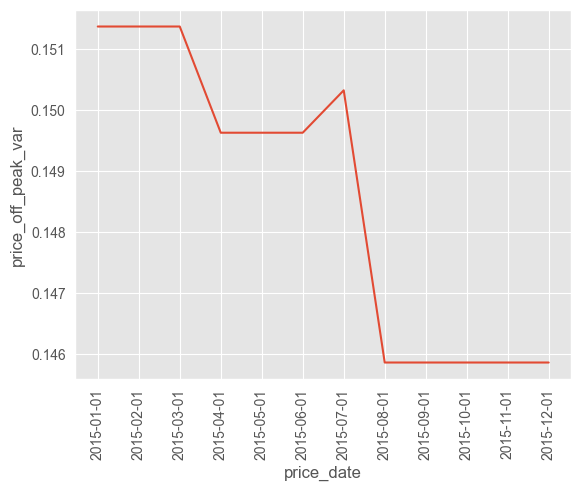

In [54]:
#Visualize one the prices 
sns.lineplot(data = prices_random_client, x = 'price_date', y = 'price_off_peak_var')
plt.xticks(rotation = 90)

### Feature Engineering in the price_data dataframe

The objective is to develop a new feature that can help predict whether a client will churn.

New dataframes:

- Dataframe with the mean prices for each client;
- Dataframe with the last price for each client (last value of the time series);
- Dataframe with the difference between the last and the first price for each client
- Dataframe of the slope of the linear regression adjusted to the prices for each client;
- Dataframe whith the standard deviation of the prices for each client.

In [55]:
numeric_columns_price = train_price_data.select_dtypes(include='number').columns.to_list()


#### Mean Price

Calculating the mean price charged during 2015. Are the mean prices higher for clients that churned?

In [56]:
#Mean price
mean_price = train_price_data.groupby('id')[numeric_columns_price].mean()
mean_price = mean_price.reset_index()


mean_price.columns = ['id'] + [f'mean_{col}' for col in mean_price.columns[1:]]
mean_price.head()

,id,mean_price_off_peak_var,mean_price_peak_var,mean_price_mid_peak_var,mean_price_off_peak_fix,mean_price_peak_fix,mean_price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.07316,40.701732,24.421038,16.280694
1,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.00000,45.319710,0.000000,0.000000
2,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.00000,44.266930,0.000000,0.000000
3,00184e957277eeef733a7b563fdabd06,0.147637,0.000000,0.00000,44.266930,0.000000,0.000000
4,001987ed9dbdab4efa274a9c7233e1f4,0.122756,0.102290,0.07303,40.647427,24.388455,16.258972


Creating four new features:

- Mean of the energy price in the three periods (off-peak, mid-peak and peak);
- Mean of the potency price in the three periods;
- Difference between the energy prices in the peak period and off-peak periods;
- Difference between the potency price in the peak and off-peak periods.

In [57]:
energy_columns  = [feature for feature in mean_price.columns if 'var' in feature]
potency_columns = [feature for feature in mean_price.columns if 'fix' in feature]

mean_price['mean_energy_price'] = mean_price[energy_columns].mean(axis = 1)
mean_price['mean_potency_price'] = mean_price[potency_columns].mean(axis = 1)

mean_price['energy_peak_minus_offpeak']  = mean_price['mean_price_peak_var'] - mean_price['mean_price_off_peak_var']
mean_price['potency_peak_minus_offpeak'] = mean_price['mean_price_peak_fix'] - mean_price['mean_price_off_peak_fix']


#### Last Price

The price charged for each client in December 2015 (the last entry of the time series)

In [58]:
#Last price (last value of the time series)

last_price = train_price_data.loc[train_price_data.groupby('id')['price_date'].idxmax()]
last_price = last_price.reset_index(drop=True)
last_price = last_price.drop(columns = ['price_date'])

last_price.columns = ['id'] + [f'last_{col}' for col in last_price.columns[1:]] 
last_price.head()

,id,last_price_off_peak_var,last_price_peak_var,last_price_mid_peak_var,last_price_off_peak_fix,last_price_peak_fix,last_price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555
1,0010bcc39e42b3c2131ed2ce55246e3c,0.201280,0.000000,0.000000,45.944710,0.00000,0.000000
2,00114d74e963e47177db89bc70108537,0.145440,0.000000,0.000000,44.266930,0.00000,0.000000
3,00184e957277eeef733a7b563fdabd06,0.145093,0.000000,0.000000,44.266930,0.00000,0.000000
4,001987ed9dbdab4efa274a9c7233e1f4,0.118175,0.100491,0.074516,40.728885,24.43733,16.291555


#### Difference between the first and last price for each client

Difference between the price charged in December 2015 and January 2015. The hypothesis is that the larger the difference (indicating that the prices increased during 2015), the higher the probability of a client quitting the service.


In [59]:
last = train_price_data.loc[train_price_data.groupby('id')['price_date'].idxmax()].set_index('id', drop = True)
last = last.drop(columns = ['price_date'])
first = train_price_data.loc[train_price_data.groupby('id')['price_date'].idxmin()].set_index('id', drop = True)
first = first.drop(columns = ['price_date'])

In [60]:
difference_last_first_prices = last - first


In [61]:
difference_last_first_prices.head()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
id,,,,,,
0002203ffbb812588b632b9e628cc38d,-0.006192,-0.002302,0.003487,0.162916,0.097749,0.065166
0010bcc39e42b3c2131ed2ce55246e3c,0.050443,0.000000,0.000000,1.500000,0.000000,0.000000
00114d74e963e47177db89bc70108537,-0.003994,0.000000,0.000000,-0.000001,0.000000,0.000000
00184e957277eeef733a7b563fdabd06,-0.004111,0.000000,0.000000,-0.000001,0.000000,0.000000
001987ed9dbdab4efa274a9c7233e1f4,-0.007801,-0.002904,0.002980,0.162916,0.097749,0.065166


In [62]:
features_difference = [feature + '_difference' for feature in difference_last_first_prices]
difference_last_first_prices.columns = features_difference
difference_last_first_prices.reset_index(inplace = True)


#### Slope of the linear regression

Adjusting a linear regression to the price data of each client. The slopes of the linear regression will indicate if the prices decreased or increased during 2015. The hypothesis is that the larger the value of the linear regression slopes, the higher the probability of the client quitting the service.


In [63]:
agg_dict = {
    f'{col}_slope' : (col, lambda x: linregress(np.arange(len(x)), x).slope)
    for col in numeric_columns_price
}

slopes_regression = train_price_data.groupby('id').agg(**agg_dict)
slopes_regression = slopes_regression.reset_index()
slopes_regression.head()

,id,price_off_peak_var_slope,price_peak_var_slope,price_mid_peak_var_slope,price_off_peak_fix_slope,price_peak_fix_slope,price_mid_peak_fix_slope
0,0002203ffbb812588b632b9e628cc38d,-0.000861,-0.000380,0.000241,1.139270e-02,0.006836,0.004557
1,0010bcc39e42b3c2131ed2ce55246e3c,0.006057,0.000000,0.000000,1.835664e-01,0.000000,0.000000
2,00114d74e963e47177db89bc70108537,-0.000502,0.000000,0.000000,-1.342657e-07,0.000000,0.000000
3,00184e957277eeef733a7b563fdabd06,-0.000522,0.000000,0.000000,-1.342657e-07,0.000000,0.000000
4,001987ed9dbdab4efa274a9c7233e1f4,-0.000953,-0.000351,0.000375,2.050686e-02,0.012304,0.008203


#### Standard Deviation

The standard deviation of the prices indicates the intensity of price variations during 2015. The hypothesis is that clients that churned had a larger variation in the prices that they were charged.


In [64]:
std_price = train_price_data.groupby('id')[numeric_columns_price].std()
std_price = std_price.reset_index()

std_price.columns = ['id'] + [f'std_{col}' for col in std_price.columns[1:]]
std_price.head()

,id,std_price_off_peak_var,std_price_peak_var,std_price_mid_peak_var,std_price_off_peak_fix,std_price_peak_fix,std_price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.003976,0.001989,0.001368,6.341481e-02,0.038049,0.025366
1,0010bcc39e42b3c2131ed2ce55246e3c,0.026008,0.000000,0.000000,7.723930e-01,0.000000,0.000000
2,00114d74e963e47177db89bc70108537,0.002202,0.000000,0.000000,5.908392e-07,0.000000,0.000000
3,00184e957277eeef733a7b563fdabd06,0.002250,0.000000,0.000000,5.908392e-07,0.000000,0.000000
4,001987ed9dbdab4efa274a9c7233e1f4,0.004045,0.001627,0.001561,8.507990e-02,0.051048,0.034032


### Concatenating DataFrames

- Concatenar quatro dataframes:

1) client_data
2) mean_price
3) last_price
4) slopes_regression
5) difference_last_first_prices
6) std_price

In [65]:
dataframes_list = [train_client_data,
                   mean_price,
                   last_price,
                   slopes_regression,
                   difference_last_first_prices,
                   std_price]

In [66]:
train_merged_client_price_data = reduce(lambda left, right: pd.merge(left, right, on='id', how='inner'), dataframes_list)

# EDA - New Features 

## Bivariate Statistics

In [67]:
bivariate_stats_new_features = bivariate_stats(train_merged_client_price_data, target = 'churn')

In [68]:
bivariate_stats_new_features.loc[bivariate_stats_new_features['r'] == '-', 'r'] = np.nan
bivariate_stats_new_features.loc[bivariate_stats_new_features['spearman'] == '-', 'spearman'] = np.nan
bivariate_stats_new_features.loc[bivariate_stats_new_features['kendalltau'] == '-', 'kendalltau'] = np.nan


bivariate_stats_new_features.sort_values(by = 'r', ascending = False)

,missing,type,unique_values,skew,pearson_pvalue,r,y = mx + b,spearman,spearman_pvalue,kendalltau,kendalltau_pvalue,chi2,chi2_pvalue,ttest,ttest_pvalue,F,F_pvalue
margin_gross_pow_ele,0.0%,float64,-,4.575,0.0,0.099,y = 0.001x + 0.062,0.106,0.0,0.087,0.0,-,-,-,-,-,-
margin_net_pow_ele,0.0%,float64,-,4.576,0.0,0.099,y = 0.001x + 0.062,0.106,0.0,0.087,0.0,-,-,-,-,-,-
mean_potency_price,0.0%,float64,-,0.354,0.0,0.054,y = 0.003x + 0.048,0.052,0.0,0.043,0.0,-,-,-,-,-,-
mean_price_peak_fix,0.0%,float64,-,0.538,0.0,0.049,y = 0.001x + 0.086,0.047,0.0,0.043,0.0,-,-,-,-,-,-
mean_price_mid_peak_var,0.0%,float64,-,0.495,0.0,0.049,y = 0.407x + 0.086,0.051,0.0,0.046,0.0,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
date_end,0.0%,object,-,2.721,-,NaN,-,NaN,-,NaN,-,-,-,-,-,1.207,0.005
date_modif_prod,0.0%,object,-,2.721,-,NaN,-,NaN,-,NaN,-,-,-,-,-,1.123,0.0
date_renewal,0.0%,object,-,2.721,-,NaN,-,NaN,-,NaN,-,-,-,-,-,0.975,0.621
has_gas,0.0%,object,-,-,-,NaN,-,NaN,-,NaN,-,-,-,1.846,0.065,-,-


## Mean Prices

In [69]:
features_mean = [feature for feature in train_merged_client_price_data.columns if 'mean' in feature or feature == 'churn']

means_churned_not_churned = train_merged_client_price_data.loc[:, features_mean].groupby('churn').mean()
means_churned_not_churned.reset_index(inplace = True)


2025-06-04 09:24:42,868 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:42,878 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


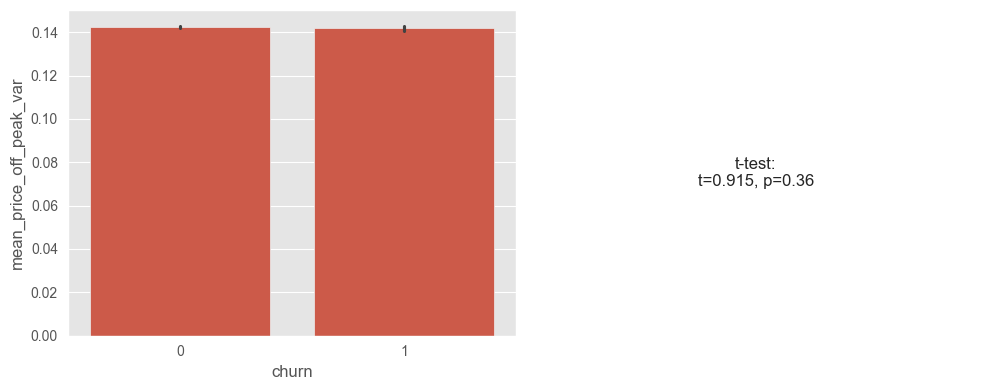

2025-06-04 09:24:43,080 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:43,090 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


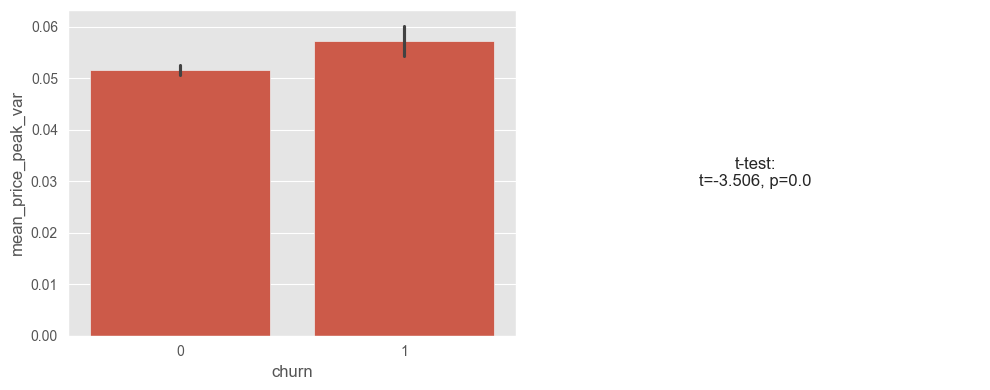

2025-06-04 09:24:43,282 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:43,291 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


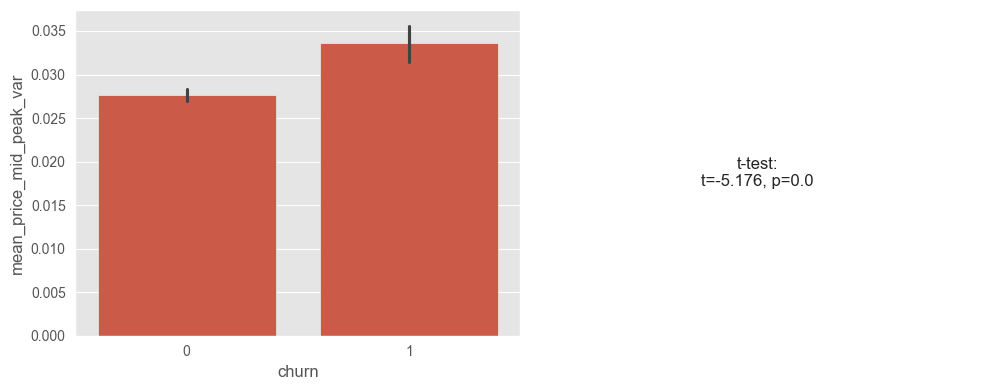

2025-06-04 09:24:43,482 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:43,494 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


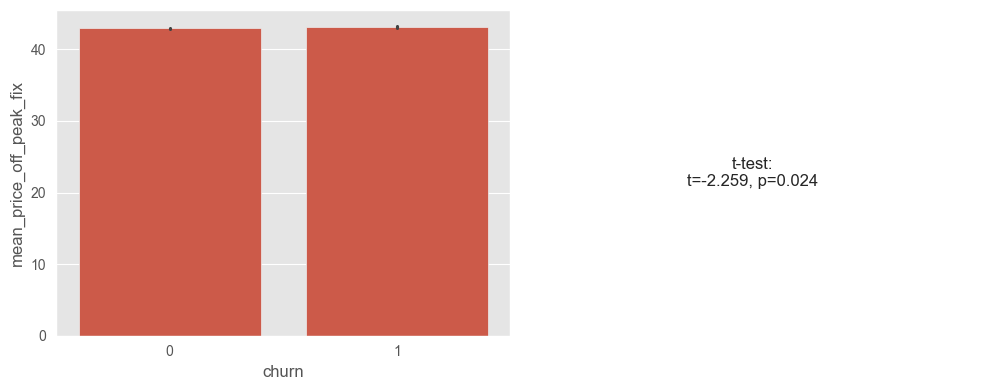

2025-06-04 09:24:43,675 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:43,684 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


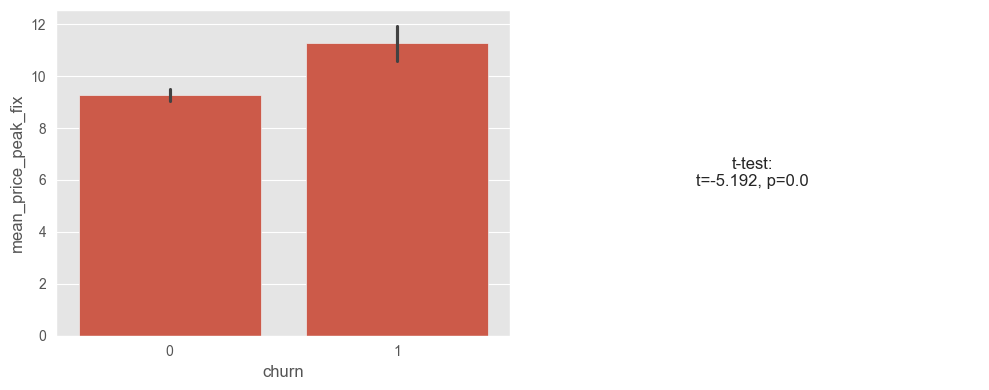

2025-06-04 09:24:43,944 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:43,953 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


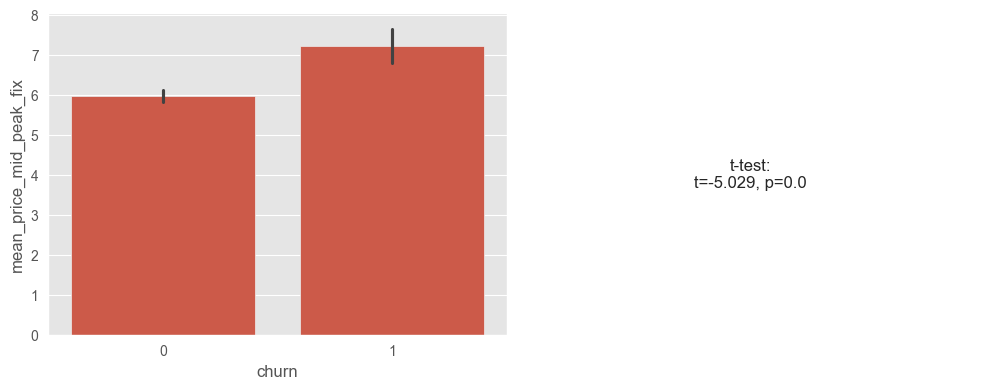

2025-06-04 09:24:44,164 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:44,174 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


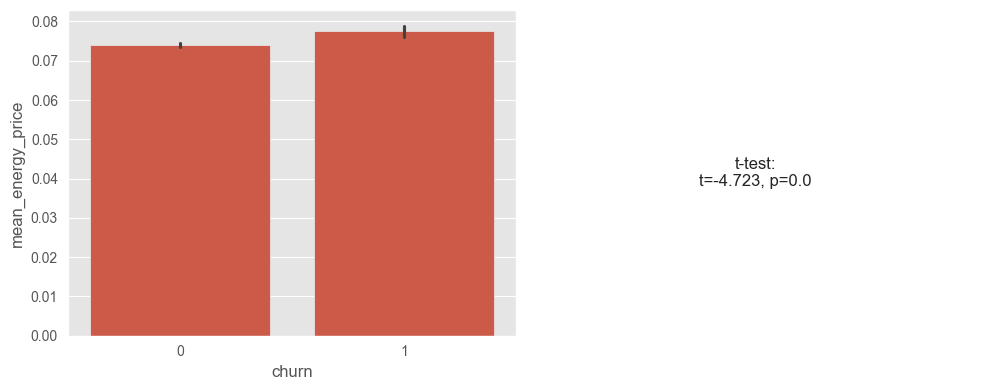

2025-06-04 09:24:44,378 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:44,388 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


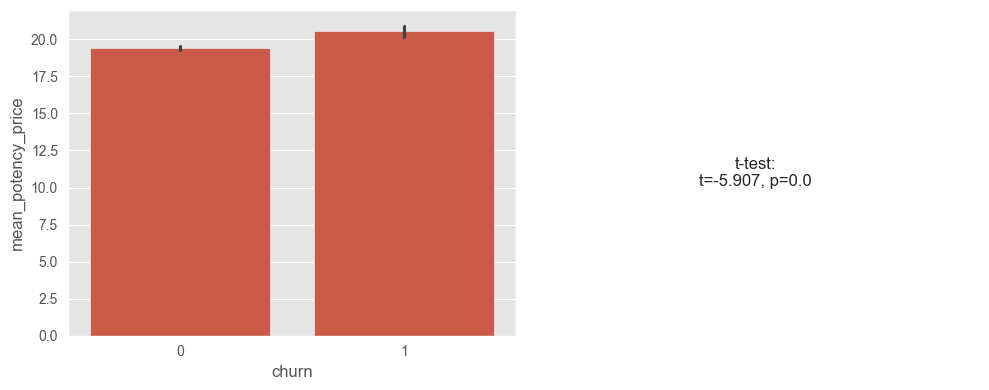

In [70]:
for feature in features_mean:
    if feature != 'churn':
        generate_bar_plot(train_merged_client_price_data, feature, 'churn', plot_type='bar')

## Last Prices

In [71]:
features_last = [feature for feature in train_merged_client_price_data.columns if 'last_price' in feature or feature == 'churn']
features_last

['churn',
 'last_price_off_peak_var',
 'last_price_peak_var',
 'last_price_mid_peak_var',
 'last_price_off_peak_fix',
 'last_price_peak_fix',
 'last_price_mid_peak_fix']

2025-06-04 09:24:44,608 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:44,619 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


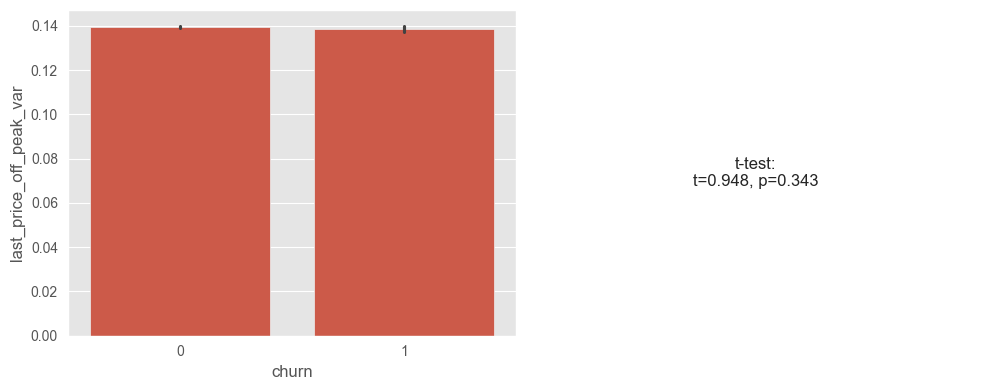

2025-06-04 09:24:44,824 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:44,833 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


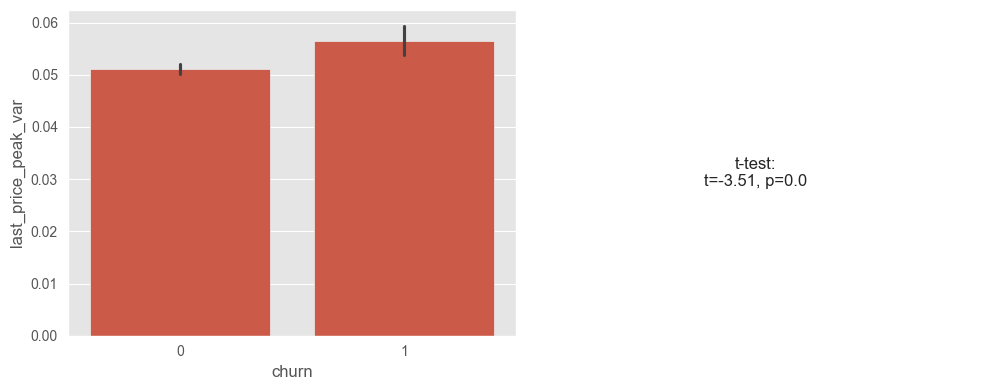

2025-06-04 09:24:45,031 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:45,042 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


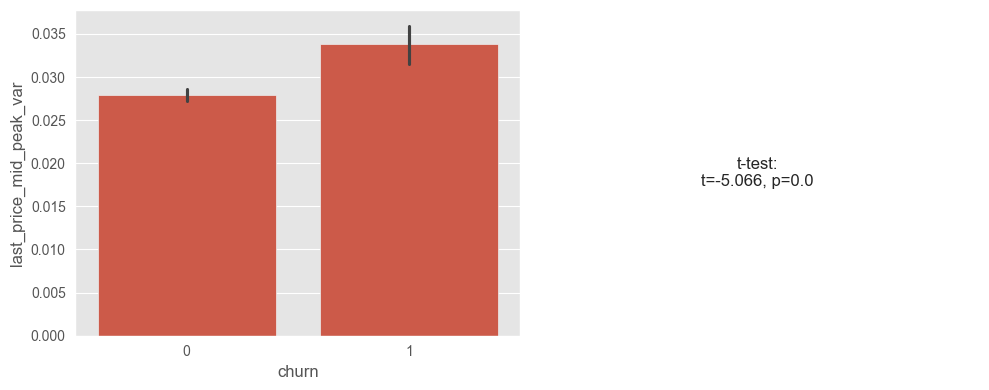

2025-06-04 09:24:45,230 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:45,240 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


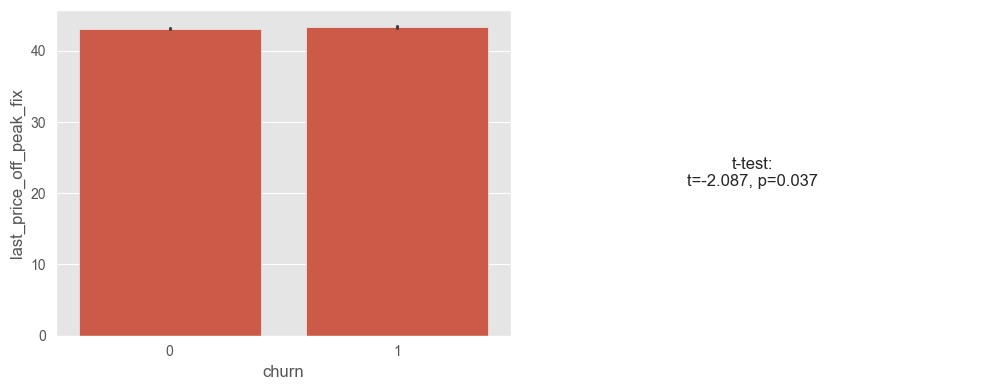

2025-06-04 09:24:45,420 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:45,429 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


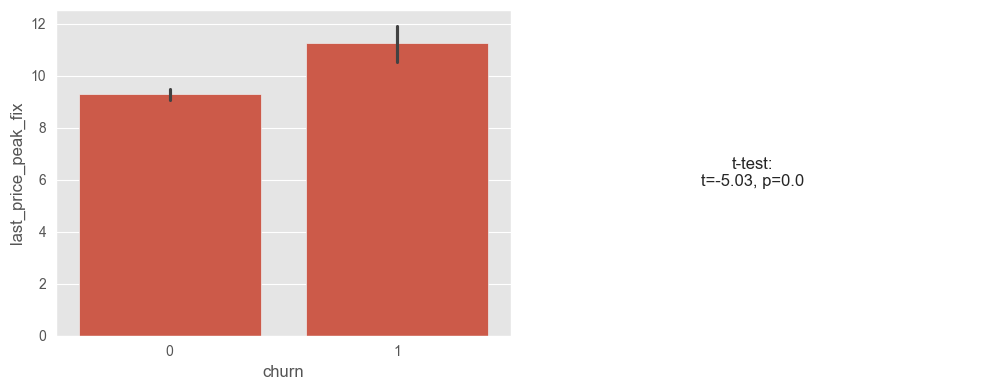

2025-06-04 09:24:45,616 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:45,626 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


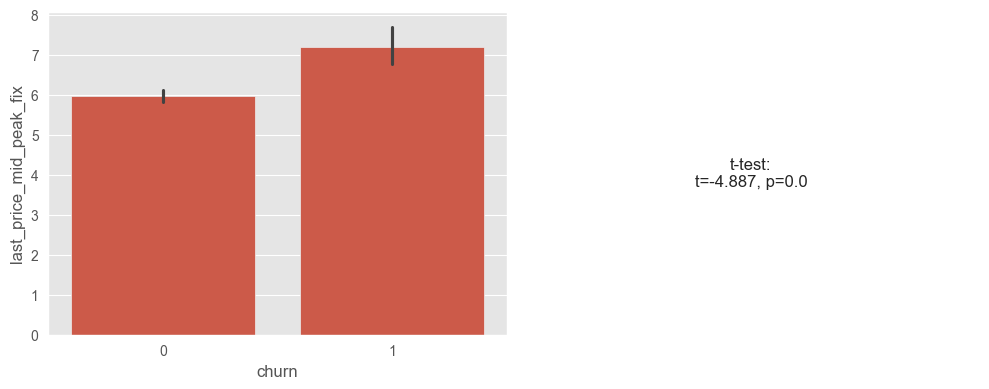

In [72]:
for feature in features_last:
    if feature != 'churn':
        generate_bar_plot(train_merged_client_price_data, feature, 'churn', plot_type='bar')

## Slope Features

Calculating the proportion of clients that have positive, negative, or null slopes to check if the proportions differ between clients that churned and those that dont


In [73]:
features_slope = [feature for feature in train_merged_client_price_data.columns if 'slope' in feature or feature == 'churn']
features_slope

['churn',
 'price_off_peak_var_slope',
 'price_peak_var_slope',
 'price_mid_peak_var_slope',
 'price_off_peak_fix_slope',
 'price_peak_fix_slope',
 'price_mid_peak_fix_slope']

In [74]:
keys = [] #slope columns
lista_dfs_pos_neg = [] 
for feature in features_slope:
    if 'slope'in feature:
        keys.append(feature)
        df_pos_neg = train_merged_client_price_data.groupby('churn').agg(
            positive_slope = (feature, lambda x: (x > 0).sum()), #number of clients (slope>0)
            negative_slope = (feature, lambda x: (x < 0).sum()), 
            null_slope =     (feature, lambda x: (x == 0).sum())) 
        df_pos_neg = df_pos_neg.div(df_pos_neg.sum(axis = 1), axis = 0) * 100 
        lista_dfs_pos_neg.append(df_pos_neg)
proportion_slopes = pd.concat(lista_dfs_pos_neg, keys = keys) 

proportion_slopes
        

positive_slope  negative_slope  null_slope
                         churn                                            
price_off_peak_var_slope 0            3.422125       95.819509    0.758366
                         1            4.317181       95.682819    0.000000
price_peak_var_slope     0           11.555598       44.373874   44.070528
                         1            9.339207       51.365639   39.295154
price_mid_peak_var_slope 0           27.813063        9.555408   62.631529
                         1           33.480176       12.246696   54.273128
price_off_peak_fix_slope 0           76.528581       14.077164    9.394255
                         1           76.828194       13.039648   10.132159
price_peak_fix_slope     0           27.348564        5.611906   67.039530
                         1           31.453744        8.193833   60.352423
price_mid_peak_fix_slope 0           27.623471        5.336999   67.039530
                         1           31.806167        7.841410   60.352423

2025-06-04 09:24:45,918 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:45,929 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


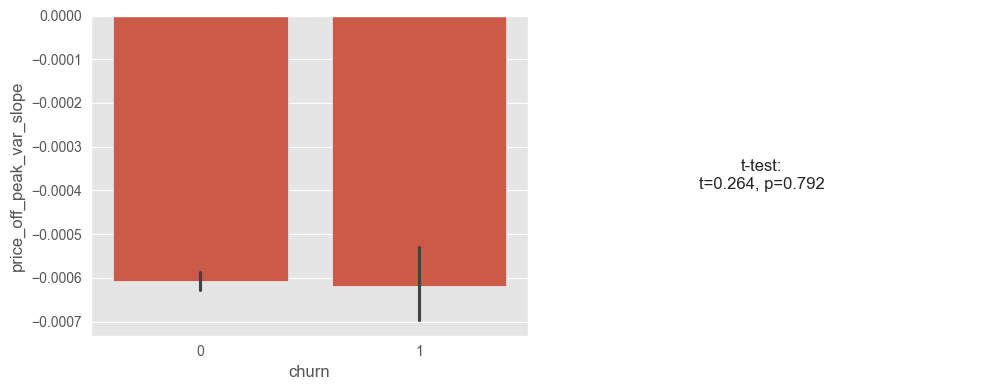

2025-06-04 09:24:46,128 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:46,137 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


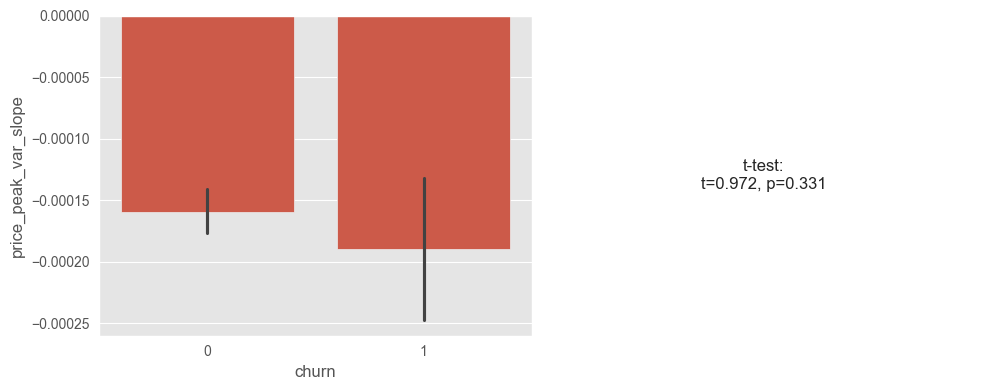

2025-06-04 09:24:46,325 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:46,333 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


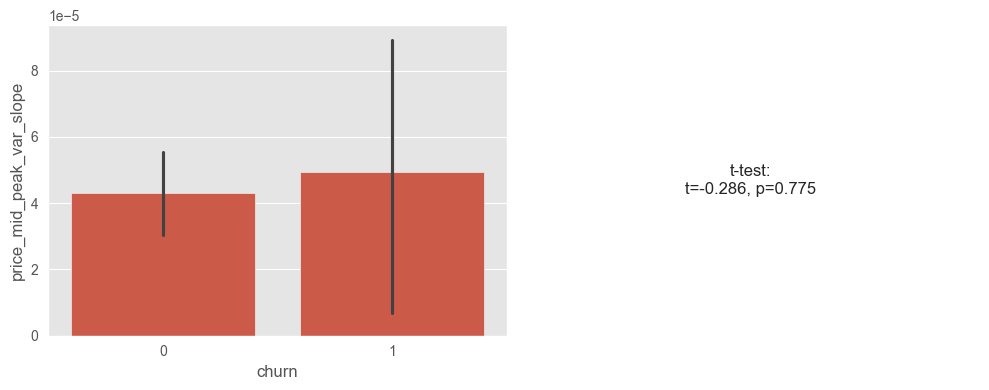

2025-06-04 09:24:46,513 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:46,522 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


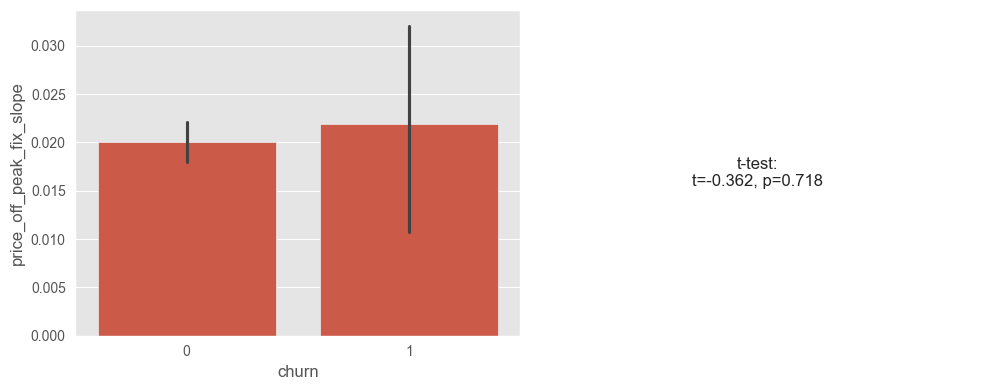

2025-06-04 09:24:46,714 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:46,724 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


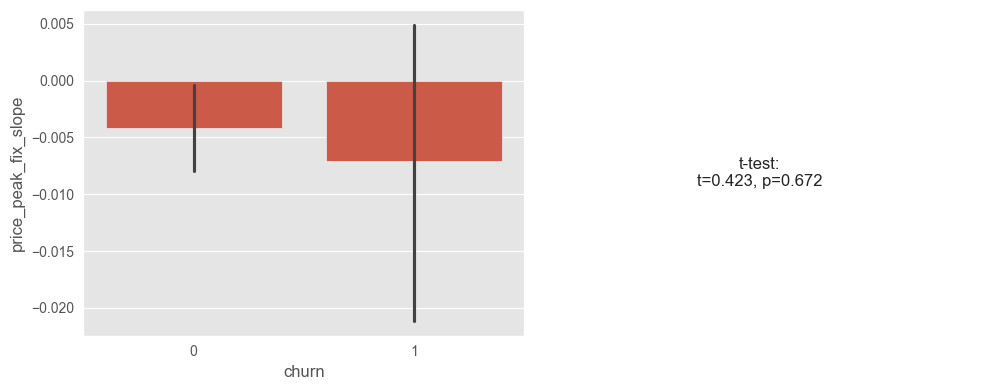

2025-06-04 09:24:46,911 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:46,919 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


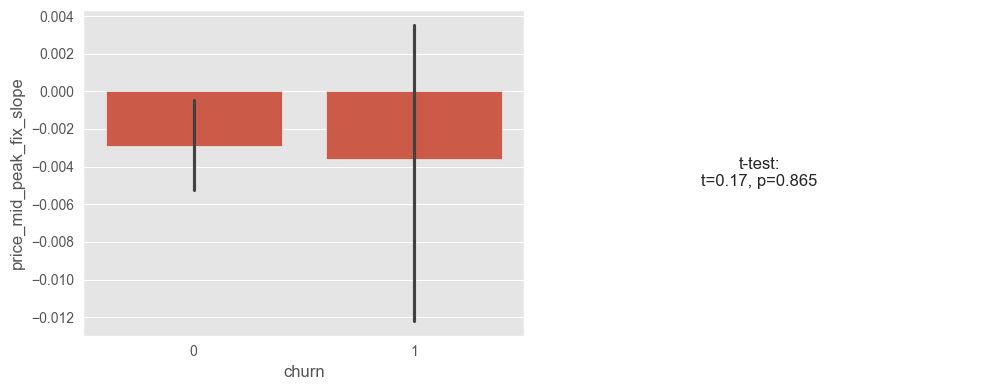

In [75]:
for feature in features_slope:
    if feature != 'churn':
        generate_bar_plot(train_merged_client_price_data, feature, 'churn', plot_type='bar')

## Features with the difference between last and first prices

In [76]:
difference_columns = [feature for feature in train_merged_client_price_data.columns if 'difference' in feature or feature == 'churn']   
difference_columns

['churn',
 'price_off_peak_var_difference',
 'price_peak_var_difference',
 'price_mid_peak_var_difference',
 'price_off_peak_fix_difference',
 'price_peak_fix_difference',
 'price_mid_peak_fix_difference']

In [77]:
keys = [] #slope columns
lista_dfs_pos_neg = [] 
for feature in difference_columns:
    if 'difference'in feature:
        keys.append(feature)
        df_pos_neg = train_merged_client_price_data.groupby('churn').agg(
            positive_diff = (feature, lambda x: (x > 0).sum()), #number of clients (slope>0)
            negative_diff = (feature, lambda x: (x < 0).sum()), 
            null_diff =     (feature, lambda x: (x == 0).sum())) 
        df_pos_neg = df_pos_neg.div(df_pos_neg.sum(axis = 1), axis = 0) * 100 
        lista_dfs_pos_neg.append(df_pos_neg)
proportion_diff = pd.concat(lista_dfs_pos_neg, keys = keys) 

proportion_diff

positive_diff  negative_diff  null_diff
                              churn                                         
price_off_peak_var_difference 0           4.227889      95.013745   0.758366
                              1           5.550661      94.449339   0.000000
price_peak_var_difference     0          12.171770      40.307138  47.521092
                              1          10.220264      46.872247  42.907489
price_mid_peak_var_difference 0          28.912693       8.436819  62.650488
                              1          34.713656      11.013216  54.273128
price_off_peak_fix_difference 0          77.097355      13.176604   9.726040
                              1          77.180617      11.718062  11.101322
price_peak_fix_difference     0          27.509717       5.318040  67.172244
                              1          31.013216       8.017621  60.969163
price_mid_peak_fix_difference 0          27.822542       5.005214  67.172244
                              1          31.541850       7.488987  60.969163

2025-06-04 09:24:47,190 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:47,198 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


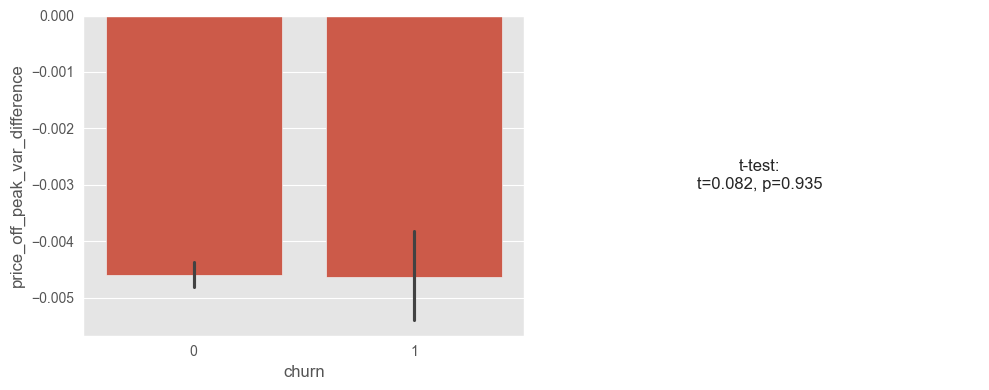

2025-06-04 09:24:47,386 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:47,396 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


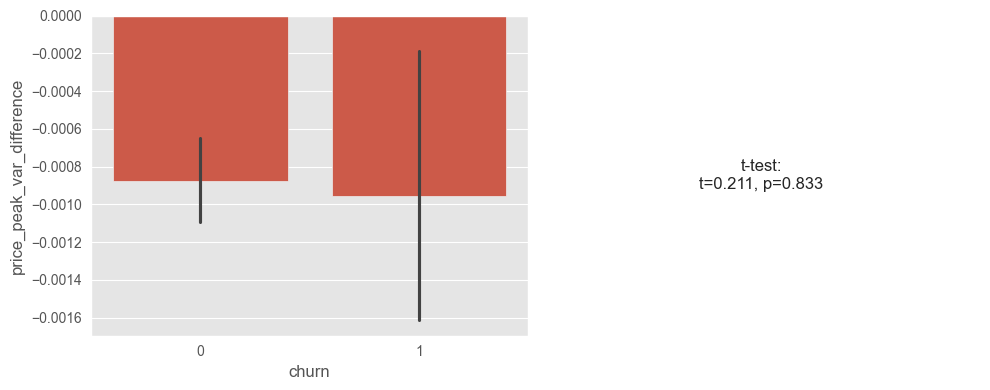

2025-06-04 09:24:47,596 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:47,606 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


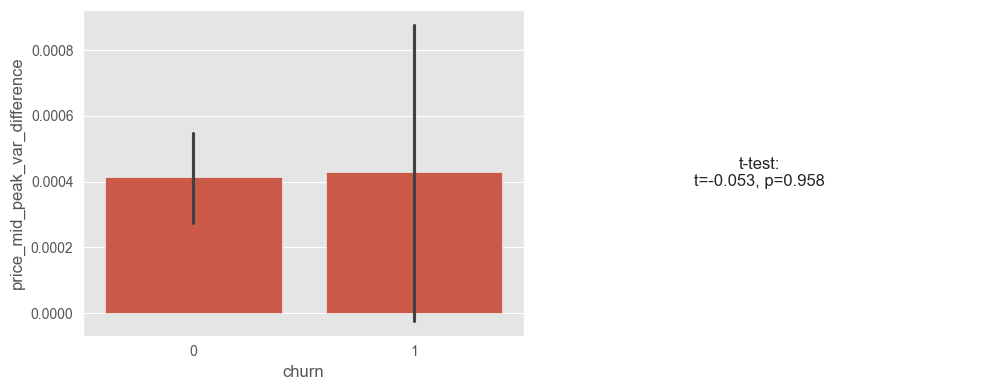

2025-06-04 09:24:47,956 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:47,967 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


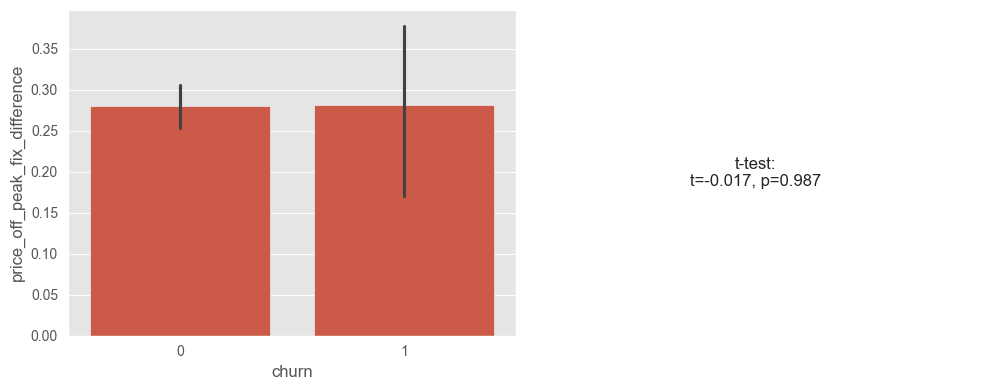

2025-06-04 09:24:48,162 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:48,172 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


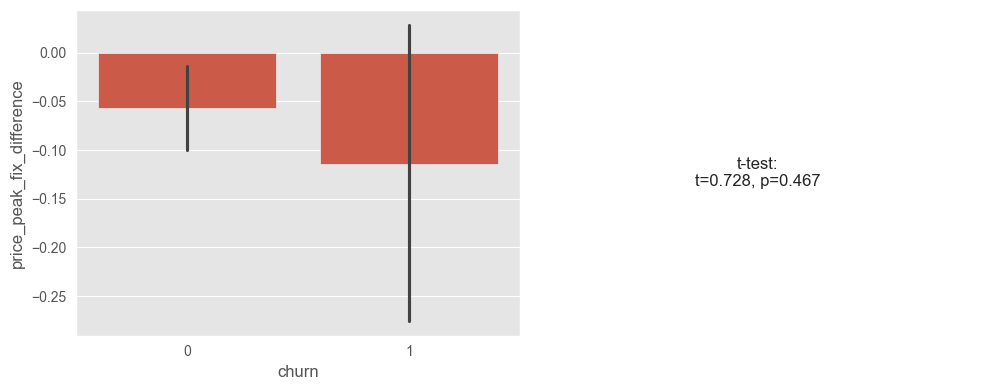

2025-06-04 09:24:48,358 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:48,366 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


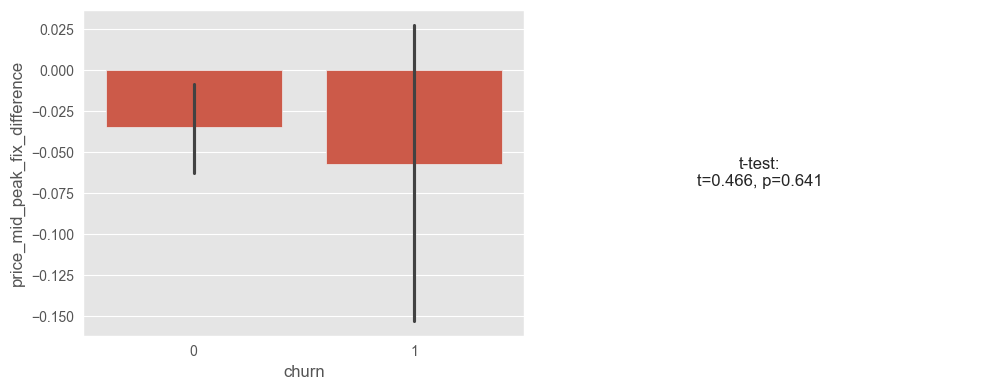

In [78]:
for feature in difference_columns:
    if feature != 'churn':
        generate_bar_plot(train_merged_client_price_data, feature, 'churn', plot_type='bar')

## Features with Standard Deviation

In [79]:
std_columns = [feature for feature in train_merged_client_price_data.columns if 'std' in feature or feature == 'churn']

2025-06-04 09:24:48,580 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:48,589 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


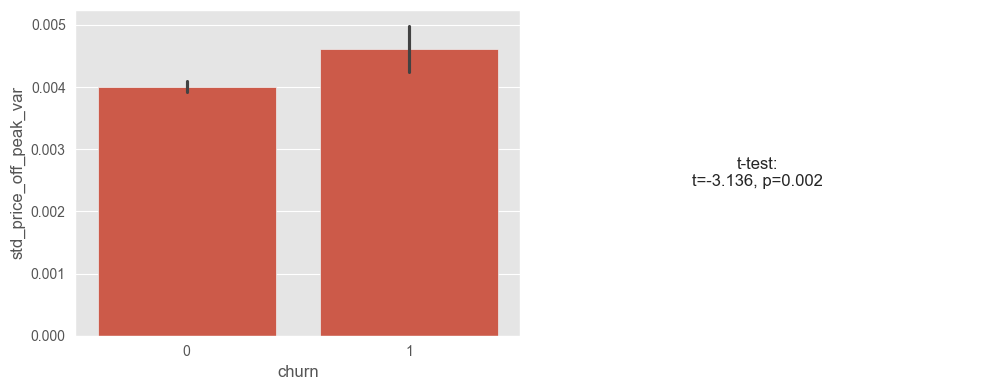

2025-06-04 09:24:48,778 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:48,786 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


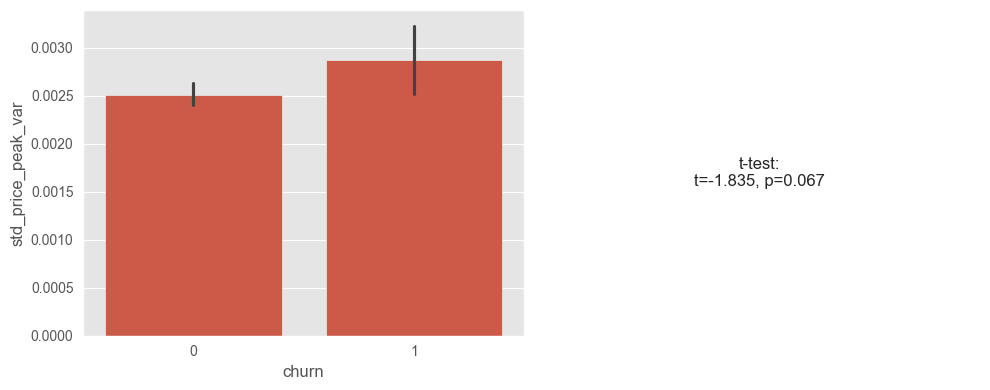

2025-06-04 09:24:48,983 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:48,994 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


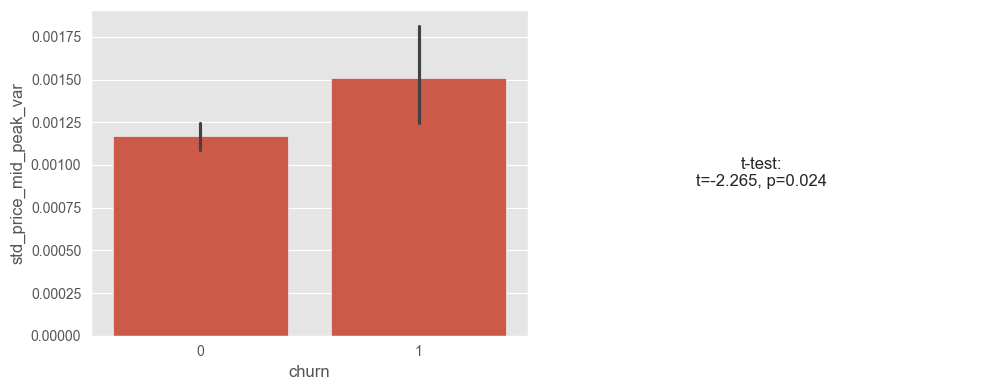

2025-06-04 09:24:49,191 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:49,200 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


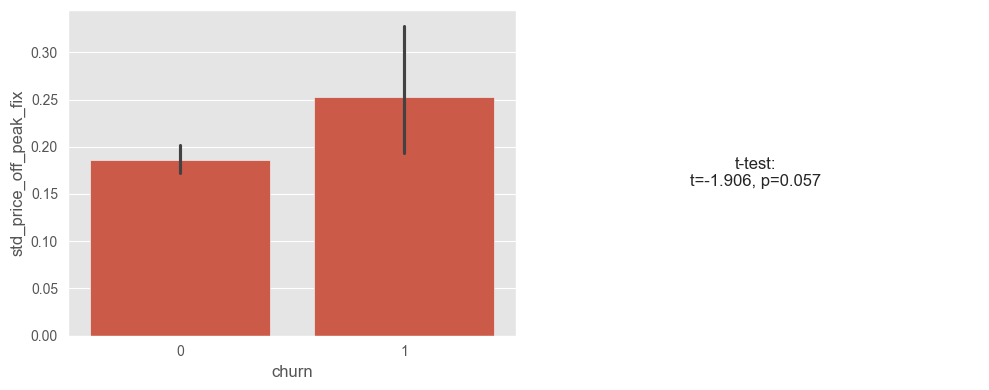

2025-06-04 09:24:49,394 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:49,402 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


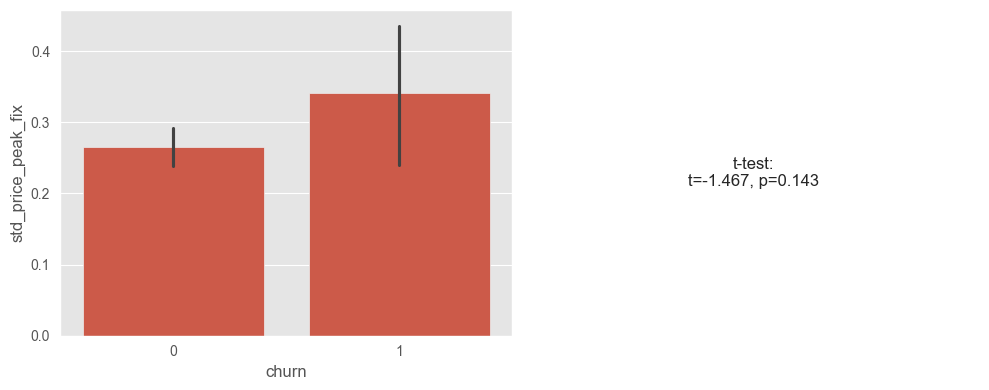

2025-06-04 09:24:49,589 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-04 09:24:49,597 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


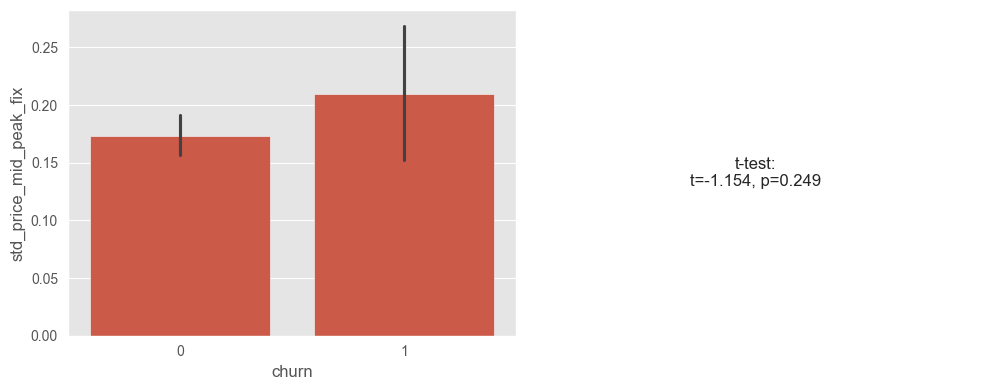

In [80]:
for feature in std_columns:
    if feature != 'churn':
        generate_bar_plot(train_merged_client_price_data, feature, 'churn', plot_type='bar')

# Saving Dataframes

In [210]:
train_client_data.to_csv('../data/raw/train/train_client_data.csv', index = False)
test_client_data.to_csv('../data/raw/test/test_client_data.csv', index = False)


In [212]:
train_price_data.to_csv('../data/raw/train/train_price_data.csv', index = False)
test_price_data.to_csv('../data/raw/test/test_price_data.csv', index = False)